In [12]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale

from pullDate_FullPeriod import pull_data , pull_seas 


# Python local connection to Oracle (herccrt) and Teradata (mosaic)
def connect_to_servers():
    from config import  herccrt,mosaic, azure
    hcrt = herccrt().con()
    mos = mosaic().con()
    az = azure().con()
    return hcrt, mos, az

# jupyter notebook settings
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20) # DON't Use None, it will show every row --> resulting in CRASH

hcrt, mos, az = connect_to_servers()

In [13]:
# choose directional market leg
orig = 'PHX'
dest = 'DFW'
### HAS UCLL:
# orig = 'DEN'
# dest = 'DFW'

new_market = False # change this to True if it is a new market

# choose fcst_id
fcst_id = 1


# constants
cabin = 'Y'
ulcc_list = ['NK','SY','F9'] # Spirit SunCountry Frontier 


# pull data time range
# pull_start = '2015-09-01'
# pull_end = '2023-12-30'

next_year_today = datetime.today() + timedelta(days=365)
yesterday =  datetime.today() - timedelta(days=1)

pull_start = '2017-09-01'
# pull_end = next_year_today.strftime("%Y-%m-%d")
pull_end = yesterday.strftime("%Y-%m-%d")

# Pre: pre-covid period, used for train and validation
Pre_start, Pre_end = '2017-09-01', '2020-01-30'
# Post: post-covid period, used for test
# Post_start, Post_end = '2021-07-01', '2022-06-30'
Post_start, Post_end = '2021-07-01', pull_end


# # !!! update here if use another fcst_id - NOT Sure what is this!
# fcst_start = 988
# fcst_end = 1619

In [14]:
def find_all_dest_given_leg(orig, hcrt):
    """Finds all destination cities given a orig code:

    Args:
        orig (string): Origen Airport Code
        hcrt (cx_Oracle.Connection): herccrt().con()

    Returns:
        list: list of all Destination flying from the given orig
    """    

    fcst_id_qry = f"""
    select Distinct LEG_DEST_S as dest
    from fcst.fcst_id_ref
    where LEG_ORIG_S = '{orig}'
    """
    fcst_id_df = pd.read_sql_query(fcst_id_qry, con=hcrt)

    return list(value[0] for value in fcst_id_df.values)


def get_fcst_given_leg(orig, dest, hcrt):
    """ Finds fcst_id and start and end of the fcst time_bounds for a given orig and dest

    Args:
        orig (string): Origen Airport Code
        dest (string): Destination Airport Code
        hcrt (cx_Oracle.Connection): herccrt().con()

    Returns:
        _type_: _description_
    """    

    fcst_id_qry = f"""
    select Distinct LEG_ORIG_S as orig, LEG_DEST_S as dest, FCST_ID as fcst_id,
            TIME_BAND_START as time_band_start, TIME_BAND_END as time_band_end
    from fcst.fcst_id_ref
    where 1=1
    and LEG_ORIG_S = '{orig}'
    and LEG_DEST_S = '{dest}'
    order by 1,2,3,4
    """
    fcst_id_df = pd.read_sql_query(fcst_id_qry, con=hcrt)

    return fcst_id_df


In [16]:

def get_oag_data(orig, dest, pull_start, pull_end, ulcc_list, mos):
    """Data from other airlines, showing the their rout and capacity, given dates and destinations.
    Contains the latest publication of scheduled flights.

    Args:
        orig (string): Origen Airport Code
        dest (string): Destination Airport Code
        pull_start (string): Starting bound for the pull date
        pull_end (string): Ending bound for the pull date
        ulcc_list (list): list of ULCC airline codes
        mos (pyodbc.Connection): mosaic().con()

    Returns:
        pd.DataFrame: OA flight infos with Unique keys: [orig, dest, dep_data, dep_mam, airline, flt_id]
    """

    oag_qry = f"""
    select DEP_AIRPRT_IATA_CD as orig,
            ARVL_AIRPRT_IATA_CD as dest,
            LOCAL_DEP_DT as dep_date,
            DEP_MINUTE_PAST_MDNGHT_QTY as dep_mam,
            FLIGHT_SCHD_PUBLSH_DT as snapshot_date,
            OPERAT_AIRLN_IATA_CD as airline,
            OPERAT_FLIGHT_NBR as flt_id, -- Flight Number
            EQUIP_COACH_CABIN_SEAT_QTY as seats,
            ASMS_QTY as asm,
            EQUIP_COACH_CABIN_SEAT_QTY * MILE_GREAT_CIRCLE_DISTANC_QTY as asm_y -- ASM for Coach Cabin
    from PROD_INDSTR_FLIGHT_SCHD_VW.OAG_CURR
    where 1=1
    and DEP_AIRPRT_IATA_CD = '{orig}'
    and ARVL_AIRPRT_IATA_CD = '{dest}'
    and LOCAL_DEP_DT between '{pull_start}' and '{pull_end}'
    -- and LOCAL_DEP_DT = '2022-09-12'
    -- and OPERAT_AIRLN_IATA_CD = 'AA'
    and OPERAT_PAX_FLIGHT_IND = 'Y' -- new field that determines if record is a scheduled operating flight record
    and FLIGHT_OAG_PUBLSH_CD <> 'X' -- record is active and not cancelled
    order by 1,2,3,4,5
    """

    oag_df = pd.read_sql(oag_qry, con=mos)

    # convert to datetime format
    oag_df["dep_date"] = pd.to_datetime(oag_df["dep_date"], format="%Y/%m/%d")

    # convert the dep_time before 3am to the previous dep_date
    # + Also you have ti change the dep_date for that one as well.
    oag_df["dep_mins"] = [val + 24 * 60 if val < 180 else val for val in oag_df["dep_mam"]]
    oag_df["adj_dep_date"] = [
        date - dt.timedelta(days=1) if mam < 180 else date for mam, date in zip(oag_df["dep_mam"], oag_df["dep_date"])
    ]

    # add yr, mo, wk cols
    oag_df["yr"] = oag_df["adj_dep_date"].dt.year
    oag_df["mo"] = oag_df["adj_dep_date"].dt.month
    oag_df["wk"] = oag_df["adj_dep_date"].dt.isocalendar().week
    # add ulcc indicator
    oag_df["ulcc_ind"] = [1 if val in ulcc_list else 0 for val in oag_df["airline"]]
    oag_df["seats_ulcc"] = [seats if val in ulcc_list else 0 for val, seats in zip(oag_df["airline"], oag_df["seats"])]

    return oag_df


def get_cap_data(orig, dest, pull_start, pull_end, mos, cabin="Y"):
    """_summary_

    Args:
        orig (string): Origen Airport Code
        dest (string): Destination Airport Code
        pull_start (string): Starting bound for the pull date
        pull_end (string): Ending bound for the pull date
        mos (pyodbc.Connection): mosaic().con()
        cabin (str, optional): Flight cabin class. Defaults to 'Y'.

    Returns:
        _type_: _description_
    """
    cap_query = f"""
    select LEG_DEP_AIRPRT_IATA_CD as orig,
            LEG_ARVL_AIRPRT_IATA_CD as dest,
            SCHD_LEG_DEP_DT as dep_date,
            SCHD_LEG_DEP_TM as dep_time,
            FILE_SNPSHT_DT as snapshot_date,
            LEG_CABIN_CD as cabin,
            OPERAT_AIRLN_IATA_CD as airline,
            MKT_FLIGHT_NBR as flt_id,  --Flight Number
            CABIN_CAPCTY_SEAT_QTY as seats,
            CAB_ASM_QTY as asm,
            CAB_TOT_RPM_QTY as rpm,
            CAB_TOT_REVNUE_AMT as rev,
            CAB_TOT_PAX_QTY as pax
    from PROD_RM_BUSINES_VW.LIFE_OF_FLIGHT_LEG_CABIN
    where 1=1
    and FILE_SNPSHT_DT = SCHD_LEG_DEP_DT-1 -- only extract the data one day before departure
    and LEG_DEP_AIRPRT_IATA_CD = '{orig}'
    and LEG_ARVL_AIRPRT_IATA_CD = '{dest}'
    and SCHD_LEG_DEP_DT between '{pull_start}' and '{pull_end}'
    -- and SCHD_LEG_DEP_DT = '2022-09-12'
    and LEG_CABIN_CD = '{cabin}'
    order by 1,2,3,4,5
    """

    cap_df = pd.read_sql(cap_query, con=mos)

    # convert to datetime format
    cap_df["dep_date"] = pd.to_datetime(cap_df["dep_date"], format="%Y/%m/%d")
    # cap_df['dep_time'] = pd.to_datetime(cap_df['dep_date']+cap_df['dep_time'], format='%H:%M:%S')
    cap_df["dep_time"] = pd.to_datetime(
        cap_df["dep_date"].astype(str) + " " + cap_df["dep_time"].astype(str), format="%Y/%m/%d %H:%M:%S"
    )

    # count the minutes from mid-night
    cap_df["dep_mins"] = pd.DatetimeIndex(cap_df["dep_time"]).hour * 60 + pd.DatetimeIndex(cap_df["dep_time"]).minute
    # convert the dep_time before 3am to the previous dep_date
    # + Also you have to adjust the dep_date for that one as well.
    cap_df["adj_dep_date"] = [
        date - dt.timedelta(days=1) if mam < 180 else date for mam, date in zip(cap_df["dep_mins"], cap_df["dep_date"])
    ]
    cap_df["dep_mins"] = [val + 24 * 60 if val < 180 else val for val in cap_df["dep_mins"]]

    # add yr, mo, wk
    cap_df["yr"] = cap_df["adj_dep_date"].dt.year
    cap_df["mo"] = cap_df["adj_dep_date"].dt.month
    cap_df["wk"] = cap_df["adj_dep_date"].dt.isocalendar().week

    return cap_df

In [17]:
def oag_per_day(oag_df):
    """Before focusing on each individual flight, lets look at a big bigger picture (flights per day) and compare flights done by AA with OA and UCLL in terms of available seats, flight numbers, and ASM.

    Args:
        oag_df (pd.DataFrame): OA/AA flight infos

    Returns:
        pd.DataFrame: OA/AA flights info (seats)  per day DataFrame
    """
    # get OA Cap per day.

    # groupby for the entire market (So we can calculate the Shares) - Sina changed it to per day.
    gp_cols = ["adj_dep_date", "airline"]
    agg_cols = {"seats": "sum", "asm_y": "sum", "flt_id": "count", "ulcc_ind": "sum", "seats_ulcc": "sum"}

    oag_kl_Per_airline_Day = oag_df.groupby(gp_cols).agg(agg_cols).reset_index()

    # change flt_id name as flt_ct, and asm_y to asm (since we are focusing on y cabin)
    oag_kl_Per_airline_Day.rename(
        columns={"flt_id": "flt_ct", "ulcc_ind": "ulcc_ind_mkt", "asm_y": "asm"}, inplace=True
    )

    # Now lets aggregate all airlines to have information on all airlines.
    gp_cols = ["adj_dep_date"]
    agg_cols = {"seats": "sum", "asm": "sum", "flt_ct": "sum", "ulcc_ind_mkt": "sum", "seats_ulcc": "sum"}

    oag_kl_total_Per_Day = oag_kl_Per_airline_Day.groupby(gp_cols).agg(agg_cols).reset_index()

    # Filter American flights into a separate view

    filter0 = oag_kl_Per_airline_Day["airline"] == "AA"
    oag_kl_Per_american_Day = oag_kl_Per_airline_Day[filter0]

    # Drop unrelated information
    oag_kl_Per_american_Day.drop(columns=["ulcc_ind_mkt", "seats_ulcc", "airline"], inplace=True)

    # Merge the AA data with the aggregate data
    oag_kl_total_Per_Day_and_AA = pd.merge(
        oag_kl_total_Per_Day, oag_kl_Per_american_Day, on=gp_cols, how="left", suffixes=("_All", "_AA")
    )
    oag_kl_total_Per_Day_and_AA.rename(columns={"ulcc_ind_mkt": "flt_ct_ulcc"}, inplace=True)

    # Calculate OA data.
    oag_kl_total_Per_Day_and_AA["seats_OA"] = (
        oag_kl_total_Per_Day_and_AA["seats_All"]
        - oag_kl_total_Per_Day_and_AA["seats_AA"]
        - oag_kl_total_Per_Day_and_AA["seats_ulcc"]
    )
    oag_kl_total_Per_Day_and_AA["flt_ct_OA"] = (
        oag_kl_total_Per_Day_and_AA["flt_ct_All"]
        - oag_kl_total_Per_Day_and_AA["flt_ct_AA"]
        - oag_kl_total_Per_Day_and_AA["flt_ct_ulcc"]
    )

    # Reformat the data
    oag_kl_total_Per_Day_and_AA = oag_kl_total_Per_Day_and_AA.loc[
        :,
        [
            "adj_dep_date",
            "seats_AA",
            "seats_OA",
            "seats_ulcc",
            "seats_All",
            "flt_ct_AA",
            "flt_ct_OA",
            "flt_ct_ulcc",
            "flt_ct_All",
            "asm_AA",
            "asm_All",
        ],
    ]

    return oag_kl_total_Per_Day_and_AA


def oag_per_fcst(oag_df, fcst_start, fcst_end):
    """Extracts the on the flight based on a given FCST_bond

    Args:
        oag_df (pd.DataFrame): OA/AA flight infos
        fcst_start (int): FCST time bound start (in minutes after midnight)
        fcst_end (int): FCST time bound end (in minutes after midnight)

    Returns:
        pd.DataFrame: OA/AA flights info (seats) per given FCST DataFrame
    """
    # OAG only keep the dep_mins in the fcst_id
    oag_df2 = oag_df[(oag_df["dep_mins"] >= fcst_start) & (oag_df["dep_mins"] <= fcst_end)]

    # here we only care about AA.
    gp_cols = ["adj_dep_date", "airline"]
    agg_cols = {"seats": "sum", "asm_y": "sum", "flt_id": "count", "ulcc_ind": "sum", "seats_ulcc": "sum"}

    oag_kl = oag_df2.groupby(gp_cols).agg(agg_cols).reset_index()
    # change flt_id name as flt_ct
    oag_kl.rename(columns={"flt_id": "flt_ct", "asm_y": "asm"}, inplace=True)
    oag_kl
    # groupby for the entire market (So we can calculate the Shares)
    gp_cols = ["adj_dep_date"]
    agg_cols = {"seats": "sum", "asm_y": "sum", "flt_id": "count", "ulcc_ind": "sum", "seats_ulcc": "sum"}

    oag_kl_AAOA = oag_df2.groupby(gp_cols).agg(agg_cols).reset_index()
    # change flt_id name as flt_ct
    oag_kl_AAOA.rename(columns={"flt_id": "flt_ct", "ulcc_ind": "ulcc_count", "asm_y": "asm"}, inplace=True)

    # Filter the oag_df2 to show theAA Cap (per fcst span) and merge AAOA Cap (on the specific fcst).
    filterAA = oag_kl["airline"] == "AA"
    oag_kl = oag_kl[filterAA]
    oag_kl.drop(columns=["ulcc_ind", "seats_ulcc", "airline"], inplace=True)

    oag_kl = pd.merge(oag_kl, oag_kl_AAOA, on=gp_cols, how="left", suffixes=("_AA_fcst", "_All_fcst"))

    # add OA Cap
    oag_kl["seats_OA_fcst"] = oag_kl["seats_All_fcst"] - oag_kl["seats_AA_fcst"] - oag_kl["seats_ulcc"]
    oag_kl["asm_OA_fcst"] = oag_kl["asm_All_fcst"] - oag_kl["asm_AA_fcst"]
    oag_kl["flt_ct_OA_fcst"] = oag_kl["flt_ct_All_fcst"] - oag_kl["flt_ct_AA_fcst"] - oag_kl["ulcc_count"]

    # # add AA market share
    # oag_kl['seats_share'] = oag_kl['seats_AA_fcst']/oag_kl['seats_AAOA']
    # oag_kl['asm_share'] = oag_kl['asm_AA_fcst']/oag_kl['asm_AAOA']
    # oag_kl['flt_ct_share'] = oag_kl['flt_ct_AA_fcst']/oag_kl['flt_ct_AAOA']
    # # add seats_per_flt
    # oag_kl['seats_per_flt_AA'] = oag_kl['seats_AA']/oag_kl['flt_ct_AA']
    # oag_kl['seats_per_flt_OA'] = oag_kl['seats_OA']/oag_kl['flt_ct_OA']
    # oag_kl['seats_per_flt_AAOA'] = oag_kl['seats_AAOA']/oag_kl['flt_ct_AAOA']

    oag_kl["fcst_start"] = fcst_start
    oag_kl["fcst_end"] = fcst_end
    oag_kl.rename(columns={"seats_ulcc": "seats_ulcc_fcst", "ulcc_count": "flt_ct_ulcc_fcst"}, inplace=True)

    oag_kl = oag_kl.loc[
        :,
        [
            "adj_dep_date",
            "fcst_start",
            "fcst_end",
            "seats_AA_fcst",
            "seats_OA_fcst",
            "seats_ulcc_fcst",
            "seats_All_fcst",
            "flt_ct_AA_fcst",
            "flt_ct_OA_fcst",
            "flt_ct_ulcc_fcst",
            "flt_ct_All_fcst",
            "asm_AA_fcst",
            "asm_All_fcst",
        ],
    ]

    return oag_kl


def normalize_oag_kl_fcst_total(oag_kl_fcst_total):
    """Normalizes the data using min-max scale

    Args:
        oag_kl_fcst_total (DataFrame): OAG Data

    Returns:
        DataFrame: Normalized OAG Data
    """

    # Drop Null
    oag_kl_fcst_total.dropna(inplace=True)

    # # remove the
    # oag_kl_fcst_total.drop(columns=['seats','asm','flt_ct' , 'fcst_start' , 'fcst_end'],inplace=True)

    # Normalize Cap features
    norm_cols = [
        "seats_AA_fcst",
        "seats_OA_fcst",
        "seats_ulcc_fcst",
        "seats_All_fcst",
        "flt_ct_AA_fcst",
        "flt_ct_OA_fcst",
        "flt_ct_ulcc_fcst",
        "flt_ct_All_fcst",
        "asm_AA_fcst",
        "asm_All_fcst",
        "seats_AA",
        "seats_OA",
        "seats_ulcc",
        "seats_All",
        "flt_ct_AA",
        "flt_ct_OA",
        "flt_ct_ulcc",
        "flt_ct_All",
        "asm_AA",
        "asm_All",
    ]

    oag_kl_fcst_total[norm_cols] = minmax_scale(oag_kl_fcst_total[norm_cols])

    return oag_kl_fcst_total


def aa_cap_fcst(cap_df, fcst_start, fcst_end):
    """After filtering the data by the fcst bond, here we group by all the AA flights on the departure date

    Args:
        cap_df (DataFrame): AA Cap Data
        fcst_start (int): FCST time bound start (in minutes after midnight)
        fcst_end (int): FCST time bound end (in minutes after midnight)

    Returns:
        DataFrame: Aggregated flight information per day based on given FCST
    """
    # AA Cap only keep the dep_mins in the fcst_id
    cap_df2 = cap_df[(cap_df["dep_mins"] >= fcst_start) & (cap_df["dep_mins"] <= fcst_end)]

    # get AA Cap
    gp_cols = ["dep_date"]
    agg_cols = {"seats": "sum", "asm": "sum", "flt_id": "count", "rpm": "sum", "rev": "sum", "pax": "sum"}

    cap_kl = cap_df2.groupby(gp_cols).agg(agg_cols).reset_index()
    cap_kl.rename(columns={"flt_id": "flt_ct"}, inplace=True)

    # add other Cap features
    cap_kl["rasm"] = cap_kl["rev"] / cap_kl["asm"]
    cap_kl["yield"] = cap_kl["rev"] / cap_kl["rpm"]
    cap_kl["load_fac"] = cap_kl["rpm"] / cap_kl["asm"]

    # replace N/A with 0
    # print(cap_kl.isnull().sum())
    cap_kl = cap_kl.replace(np.nan, 0)
    # print(cap_kl.isnull().sum())

    return cap_kl


def merge_oag_aacap(oag_kl, cap_kl):
    """merge both OAG and AA cap on dep_date
    And:
    1. Merge on cap_K1 (so data from OAG when CAP data is None would not be included.)
        Either data is not included because all the flights on that data are canceled (I think)
    2. 'seats','asm','airline','ulcc_ind' from the CAP are dropped (so we use the data gathered from the OAG dataset, which might be less accurate.)
    3. Data are normalized using minmax_scale

    Args:
        oag_kl (DtaFrame): OAG DF
        cap_kl (DtaFrame): AA Cap DF

    Returns:
        DtaFrame: _description_
    """
    # merge OAG and AA Cap data

    oag_kl.rename(columns={"adj_dep_date": "dep_date"}, inplace=True)

    oag_cap_kl = pd.merge(cap_kl, oag_kl, on=["dep_date"], how="left", suffixes=("_cap", "_oag"))

    # print(oag_cap_kl.isnull().sum())
    oag_cap_kl.dropna(inplace=True)

    # remove the
    oag_cap_kl.drop(columns=["seats", "asm", "flt_ct", "fcst_start", "fcst_end"], inplace=True)

    # Normalize Cap features
    norm_cols = [
        "rpm",
        "rev",
        "pax",
        "rasm",
        "yield",
        "load_fac",
        "seats_AA_fcst",
        "seats_OA_fcst",
        "seats_ulcc_fcst",
        "seats_All_fcst",
        "flt_ct_AA_fcst",
        "flt_ct_OA_fcst",
        "flt_ct_ulcc_fcst",
        "flt_ct_All_fcst",
        "asm_AA_fcst",
        "asm_All_fcst",
    ]

    oag_cap_kl[norm_cols] = minmax_scale(oag_cap_kl[norm_cols])

    return oag_cap_kl

In [18]:
def create_group_id(df):
    """Groups Data in the 14 rows (local/flow, 7 fcst_perd) x 10 cols (frac_closure), adds REAL token to the DataFrame that is already exists.
    Args:
        df (DataFrame): Given DataFrame Format

    Returns:
        DataFrame: Grouped data + real tokens
    """

    df = df.sort_values(
        [
            "snapshotDate",
            "origin",
            "destination",
            "forecastId",
            "flightDepartureDate",
            "forecastDayOfWeek",
            "poolCode",
            "cabinCode",
            "localFlowIndicator",
        ]
    )

    # 'GroupBy.cumcount': Number each item in each group from 0 to (the length of that group - 1).
    # '== 0' returns True or False
    # '.astype(int)' ,convert True/False to 1/0
    df["groupID"] = (
        df.groupby(
            [
                "snapshotDate",
                "origin",
                "destination",
                "forecastId",
                "flightDepartureDate",
                "forecastDayOfWeek",
                "poolCode",
                "cabinCode",
            ]
        ).cumcount()
        == 0
    ).astype(int)
    # assign each unique group a new group id
    # groupID==1 will be a new id (+1), groupID==0 will indicate the same id for the same group
    df["groupID"] = df["groupID"].cumsum()

    # Full History Pre Fixing
    # count the num of 'forecastPeriod' in each group
    # because some group might not have all 7 'forecastPeriod'
    df["fullHistory"] = df.groupby(["groupID"])["forecastPeriod"].transform("count")
    # Indicator it is part of history and not a pad
    df["real"] = 1
    return df


def empty_group():
    """Creates an empty group with 14 rows (local/flow, 7 fcst_perd), what we call "FAKE data".
    It is used to populate the missing data with 0 traffic

    Returns:
        DataFrame: a 14-row DataFrame of Empty values (FAKE - Date)
    """
    # Creating an empty group to be used for padding.
    fullKeysArray = np.zeros((14, 50))  # 'fullKeys' uses 50 columns

    # frac_closure = 0: fully closed with 0 traffic
    for i in range(0, fullKeysArray.shape[0]):
        if i <= 6:  # Flow: 0 ~ 6
            fullKeysArray[i][0] = 1  # 'localFlowIndicator' column
            fullKeysArray[i][1] = i + 1  # 'forecastPeriod' column: 1 ~ 7
            fullKeysArray[i][2:12] = 1  # 'fracClosure' column all set to 1
        else:  # Local: 7 ~ 13s
            fullKeysArray[i][0] = 0  # 'localFlowIndicator' column
            fullKeysArray[i][1] = i - 6  # 'forecastPeriod' column: 1 ~ 7
            fullKeysArray[i][2:12] = 1  # 'fracClosure' column: all set to 1

    fullKeys = pd.DataFrame(fullKeysArray)
    fullKeys.columns = (
        ["localFlowIndicator", "forecastPeriod"]
        + [f"fracClosure_{i}" for i in range(1, 11)]
        + [f"trafficActual_{i}" for i in range(1, 11)]
        + [f"trafficActualAadv_{i}" for i in range(1, 11)]
        + [
            "holiday",
            "H1",
            "H2",
            "H3",
            "HL",
            "weekNumber",
            "week_x",
            "week_y",
            "dow_x",
            "dow_y",
            "avgtraffic",
            "avgtrafficopenness",
            "avgrasm",
            "dowavgtraffic",
            "dowavgtrafficopenness",
            "dowavgrasm",
            "groupID",
            "fullHistory",
        ]
    )
    fullKeys["localFlowIndicator"] = ["F" if lfi == 1 else "L" for lfi in fullKeys["localFlowIndicator"]]
    return fullKeys


def empty_group_future():
    """This function works similar to the empty_group, but instead of populating traffic with 0 it populates it with -1.
    it is used for future flights where we have not closed the periods yet.

    Returns:
        _type_: _description_
    """
    # Creating an empty group to be used for padding.
    fullKeysArray = np.zeros((14, 50))  # 'fullKeys' uses 50 columns

    # frac_closure = 0: fully closed with 0 traffic
    for i in range(0, fullKeysArray.shape[0]):
        if i <= 6:  # Flow: 0 ~ 6
            fullKeysArray[i][0] = 1  # 'localFlowIndicator' column
            fullKeysArray[i][1] = i + 1  # 'forecastPeriod' column: 1 ~ 7
            fullKeysArray[i][2:12] = 0  # 'fracClosure' column all set to 0
            fullKeysArray[i][12:32] = -1  # 'trafficActual' column all set to -1
        else:  # Local: 7 ~ 13s
            fullKeysArray[i][0] = 0  # 'localFlowIndicator' column
            fullKeysArray[i][1] = i - 6  # 'forecastPeriod' column: 1 ~ 7
            fullKeysArray[i][2:12] = 0  # 'fracClosure' column: all set to 0
            fullKeysArray[i][12:32] = -1  # 'trafficActual' column all set to -1

    fullKeys = pd.DataFrame(fullKeysArray)
    fullKeys.columns = (
        ["localFlowIndicator", "forecastPeriod"]
        + [f"fracClosure_{i}" for i in range(1, 11)]
        + [f"trafficActual_{i}" for i in range(1, 11)]
        + [f"trafficActualAadv_{i}" for i in range(1, 11)]
        + [
            "holiday",
            "H1",
            "H2",
            "H3",
            "HL",
            "weekNumber",
            "week_x",
            "week_y",
            "dow_x",
            "dow_y",
            "avgtraffic",
            "avgtrafficopenness",
            "avgrasm",
            "dowavgtraffic",
            "dowavgtrafficopenness",
            "dowavgrasm",
            "groupID",
            "fullHistory",
        ]
    )
    fullKeys["localFlowIndicator"] = ["F" if lfi == 1 else "L" for lfi in fullKeys["localFlowIndicator"]]
    fullKeys
    return fullKeys


def padding_groups(df, fullKeys):
    """This function loops through the data, and replace any missing values with the "Fake Data". (Fake Data being data that has 0 (-1) as traffic)
    It finds the time-periods (the 14 periods for each day) that are missing, and populate the "fake Data" for them.

    Args:
        df (_type_): _description_
        fullKeys (DataFrame): The empty Group (output of either empty_group or empty_group_future)

    Returns:
        _type_: _description_
    """

    groupbyColumns = [
        "snapshotDate",
        "origin",
        "destination",
        "forecastId",
        "flightDepartureDate",
        "forecastDayOfWeek",
        "poolCode",
        "cabinCode",
    ]
    grouped = df.groupby(groupbyColumns)

    merged_list = []
    count_rows_misskey = 0
    for g in grouped:

        # g[0] is the directory key and g[1] is the value (actual data)
        # identify the cells of g[1] that not in fullKeys
        # g[1][~g[1].isin(fullKeys)]

        # identify the missing keys in g[1]
        key = g[1][["localFlowIndicator", "forecastPeriod"]]
        missingKeys = fullKeys[
            ~fullKeys[["localFlowIndicator", "forecastPeriod"]].apply(tuple, 1).isin(key.apply(tuple, 1))
        ]
        count_rows_misskey += missingKeys.shape[0]

        # append the missing keys under the data
        fullHistory = pd.concat([g[1], missingKeys])

        # use 0 to indicate padding data
        fullHistory["real"].fillna(0, inplace=True)

        # fill the data with missing keys
        fullHistory = fullHistory.fillna(method="ffill")
        merged_list.append(fullHistory)

    # merge all data across 'flightDepartureDate'
    out = pd.concat(merged_list)
    out = out.sort_values(
        [
            "snapshotDate",
            "origin",
            "destination",
            "forecastId",
            "flightDepartureDate",
            "forecastDayOfWeek",
            "poolCode",
            "cabinCode",
            "localFlowIndicator",
        ]
    )

    # Get full history and then concat fake history (padding) from above
    post = out.copy()
    post = post.sort_values(
        [
            "snapshotDate",
            "origin",
            "destination",
            "forecastId",
            "flightDepartureDate",
            "forecastDayOfWeek",
            "poolCode",
            "cabinCode",
            "localFlowIndicator",
        ]
    )

    post["groupID"] = (
        post.groupby(
            [
                "snapshotDate",
                "origin",
                "destination",
                "forecastId",
                "flightDepartureDate",
                "forecastDayOfWeek",
                "poolCode",
                "cabinCode",
            ]
        ).cumcount()
        == 0
    ).astype(int)
    post["groupID"] = post["groupID"].cumsum()
    # Full Hisotyr Pre Fixing
    post["fullHistory"] = post.groupby(["groupID"])["forecastPeriod"].transform("count")

    post["flightDepartureDate"] = pd.to_datetime(post["flightDepartureDate"], format="%Y/%m/%d")

    post = post.sort_values(
        [
            "forecastDepartureDate",
            "origin",
            "destination",
            "forecastId",
            "flightDepartureDate",
            "forecastDayOfWeek",
            "poolCode",
            "cabinCode",
            "localFlowIndicator",
            "forecastPeriod",
        ]
    )
    return post


def group_and_pad(df):
    """This function calls all the above function.
    Also uses the Date-time today, to use the empty_group_future for any future data.

    Args:
        df (DataFrame): DataFrame with all the data. 

    Returns:
        DataFrame: Grouped and padded DataGFrame with "True" and "Fake" Date
    """

    yesterday = (datetime.today() - timedelta(days=2)).strftime("%Y-%m-%d")

    fullKeys = empty_group()
    fullKeysfuture = empty_group_future()

    # Divide DF in past and Future:
    df["flightDepartureDate"] = pd.to_datetime(df["flightDepartureDate"], format="%Y/%m/%d")

    df_past = df[df["flightDepartureDate"] <= yesterday]
    df_future = df[df["flightDepartureDate"] >= yesterday]

    if len(df_future) > 10:
        df_future = padding_groups(create_group_id(df_future), fullKeysfuture)
        df_past = padding_groups(create_group_id(df_past), fullKeys)
        df = pd.concat([df_past, df_future])
    else:
        df = padding_groups(create_group_id(df), fullKeys)

    return df


In [19]:
def get_tensors(DataFarame, sea_col_Cap, test = False, time_series = True , use_channels = False , seasenality_one_dimension = True ,  window = 10):
    
    len_sea_cap = len(sea_col_Cap)
            
    
    # fractional closure
    PRE_FC_L = DataFarame[['fracClosure_' + str(i + 1) for i in range(10)]].values.astype('float32')
    # seasonality
    PRE_Sea_L = DataFarame[sea_col_Cap].values.astype('float32')
    # actual traffic
    if test:
        Traffic = False
    else:
        PRE_Traf_L = DataFarame[['trafficActual_' + str(i + 1) for i in range(10)]].values.astype('float32')
    
    
    # reshape the data for CNNLSTM model
    FC = PRE_FC_L.reshape(int(PRE_FC_L.shape[0]/14), 1, 14, 10)
    Seasenality = PRE_Sea_L.reshape(int(PRE_Sea_L.shape[0]/14), 1,14, len_sea_cap)
    if not test:
        Traffic = PRE_Traf_L.reshape(int(PRE_Traf_L.shape[0]/14), 1, 14, 10)
    
    # Remove Duplicates (from 2d to 1d vector)
    if seasenality_one_dimension:
        Seasenality =np.delete(Seasenality, slice(13), 2).reshape(Seasenality.shape[0],len_sea_cap)
    
    
    if use_channels:
        FC = FC.reshape(len(FC),2,7,10)
        if not test:
            Traffic = Traffic.reshape(len(Traffic),2,7,10)
    
    # Change FC shape to refelect time series:
    # print(FC.shape)
    if time_series:
        time_series_widow= list()
        Seasenality_times = list()
        for i in range(window,len(FC)):
            # print(FC[i-window:i].shape)
            time_series_widow.append(FC[i-window:i].reshape(window,2,7,10))
            # print((Seasenality[i-window:i].shape))
            Seasenality_times.append(Seasenality[i-window:i])
        FC = np.array(time_series_widow)
        Seasenality = np.array(Seasenality_times)
        
        # Since the 1st window size data points are removed:
        # Seasenality = Seasenality[window:]
        if not test:
            Traffic = Traffic[window:]
        
        
    return FC, Seasenality, Traffic
   
    
    
def get_train_test_samples(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap , train_val_percentage = 0.9 , time_series = False, use_channels = False,  seasenality_one_dimension = True , window = 0  ):
    
    PRE_FC , PRE_Seas , PRE_Traf  = get_tensors(Data_PRE, sea_col_Cap , test = False, time_series =time_series , use_channels = use_channels , seasenality_one_dimension=seasenality_one_dimension , window =window)
    POST_FC , POST_Seas , _  = get_tensors(Data_POST, sea_col_Cap, test = True, time_series = time_series, use_channels = use_channels, seasenality_one_dimension=seasenality_one_dimension , window = window )
    # TODO: FOR NOW WE ARE NOT USING THE FUTURE:
    FUTURE_FC , FUTURE_Seas , _  = get_tensors(Data_FUTURE, sea_col_Cap ,test = True, time_series = time_series, use_channels = use_channels, seasenality_one_dimension=seasenality_one_dimension , window = window)
    
    # 80, 20 --> 
    # TODO: THIS SHOULD BE CHANGED TO RANDOMIZED.
    train_val_cutoff = round(PRE_FC.shape[0]*train_val_percentage) 


    # prepare train/val/test datasets
    PRE_FC_train = PRE_FC[:train_val_cutoff, :]
    PRE_FC_val = PRE_FC[train_val_cutoff:, :]

    PRE_Seas_train = PRE_Seas[:train_val_cutoff, :]
    PRE_Seas_val = PRE_Seas[train_val_cutoff:, :]

    PRE_Traf_train = PRE_Traf[:train_val_cutoff, :]
    PRE_Traf_val = PRE_Traf[train_val_cutoff:, :]



    train = [PRE_FC_train,PRE_Seas_train,PRE_Traf_train]
    val = [PRE_FC_val,PRE_Seas_val,PRE_Traf_val]
    test = [POST_FC,POST_Seas]
    
    return train, val, test
    

In [20]:
def randPeriod(prdMaps):
    # print(x)
    random_period = np.random.randint(1,7)
    rrd_start, rrt_end = prdMaps[prdMaps['FORECASTPERIOD']==random_period].loc[:,["RRD_START", "RRD_END"]].values[0]
    random_day = np.random.randint(rrd_start, rrt_end )
    return random_period , random_day


def tf_timeseries_masking( tf_tensors , data_index , prdMaps , window  ):
    """This function will generate masked time-seried terrafic data."""
    
    random_period , random_day_to_dept = randPeriod(prdMaps)
    # print(random_period , random_day_to_dept )
    arr =  prdMaps.iloc[:,3].values
    
    # output = tf_tensors[data_index].copy()
    test_tensors = tf_tensors.copy()
    test_tensors[data_index][:,:random_period,] = -1
    
    
    max_bond_period = random_day_to_dept
    min_bond_period = arr[random_period-1]
    remaining_window = window - 1
    current_index = data_index
    max_min_range = max_bond_period - min_bond_period
    current_period = random_period

    if  max_min_range < remaining_window:
        while max_min_range  <= remaining_window:
            # print(current_index-max_min_range,current_index)
            test_tensors[current_index-max_min_range:current_index,:,:current_period,] = -1
            current_period -= 1
            if current_period == 0:
                break
            current_index -= max_min_range
            remaining_window -=  max_min_range
            max_bond_period -= max_min_range
            min_bond_period = arr[current_period-1]
            max_min_range = max_bond_period - min_bond_period
            # reaching Today date:

    if max_min_range >= remaining_window:
        # print(current_index-max_min_range,current_index)
        test_tensors[current_index-remaining_window:current_index,:,:current_period,] = -1
    
    return test_tensors[data_index+1-window:data_index+1] 


def get_tensors2(DataFarame, sea_col_Cap, prdMaps= None , FC_time_series = True , traffic_time_series = False ,  use_channels = False , seasenality_one_dimension = True ,  window = 10, DOW=False):
    
    len_sea_cap = len(sea_col_Cap)
            
    
    # fractional closure
    PRE_FC_L = DataFarame[['fracClosure_' + str(i + 1) for i in range(10)]].values.astype('float32')
    # seasonality
    PRE_Sea_L = DataFarame[sea_col_Cap].values.astype('float32')
    # actual traffic
    PRE_Traf_L = DataFarame[['trafficActual_' + str(i + 1) for i in range(10)]].values.astype('float32')
    
    
    # reshape the data for CNNLSTM model
    FC = PRE_FC_L.reshape(int(PRE_FC_L.shape[0]/14), 1, 14, 10)
    Seasenality = PRE_Sea_L.reshape(int(PRE_Sea_L.shape[0]/14), 1,14, len_sea_cap)
    Traffic = PRE_Traf_L.reshape(int(PRE_Traf_L.shape[0]/14), 1, 14, 10)
    
    # Remove Duplicates (from 2d to 1d vector)
    if seasenality_one_dimension:
        Seasenality =np.delete(Seasenality, slice(13), 2).reshape(Seasenality.shape[0],len_sea_cap)
    
    
    if use_channels:
        FC = FC.reshape(len(FC),2,7,10)
        Traffic = Traffic.reshape(len(Traffic),2,7,10)
    
    # Change FC shape to refelect time series:
    # print(FC.shape)
    if FC_time_series:
        time_series_widow= list()
        Seasenality_times = list()
        for i in range(window,len(FC)):
            # print(FC[i-window:i].shape)
            time_series_widow.append(FC[i-window:i].reshape(window,2,7,10))
            # print((Seasenality[i-window:i].shape))
            Seasenality_times.append(Seasenality[i-window:i])
        FC = np.array(time_series_widow)
        Seasenality = np.array(Seasenality_times)
        
        # Since the 1st window size data points are removed:
        # Seasenality = Seasenality[window:]
        Traffic = Traffic[window:]
    
    elif traffic_time_series:
        traffic_time_series_window = list()
        Seasenality_times = list()
        for i in range(window,len(Traffic)):
            # Find Random period and random day:
            if DOW:
                tf_window_masked = tf_timeseries_masking_DOW( Traffic  , i , prdMaps , window  )
            else:
                tf_window_masked = tf_timeseries_masking( Traffic  , i , prdMaps , window  )
            traffic_time_series_window.append(tf_window_masked)
            # Seasenality_times.append(Seasenality[i-window:i])
        TF_time = np.array(traffic_time_series_window)
        # Seasenality = np.array(Seasenality_times)
        Seasenality = Seasenality[window:]
        FC = FC[window:]
        
        Traffic = Traffic[window:]
            
        return FC, Seasenality, Traffic, TF_time
    
        
    return FC, Seasenality, Traffic, _




def floorSearch(arr, low, high, x):
 
    # If low and high cross each other
    if (low > high):
        return -1
 
    # If last element is smaller than x
    if (x >= arr[high]):
        return high
 
    # Find the middle point
    mid = int((low + high) / 2)
 
    # If middle point is floor.
    if (arr[mid] == x):
        return mid
 
    # If x lies between mid-1 and mid
    if (mid > 0 and arr[mid-1] <= x
            and x < arr[mid]):
        return mid - 1
 
    # If x is smaller than mid,
    # floor must be in left half.
    if (x < arr[mid]):
        return floorSearch(arr, low, mid-1, x)
 
    # If mid-1 is not floor and x is greater than
    # arr[mid],
    return floorSearch(arr, mid + 1, high, x)


def tf_timeseries_masking_DOW( tf_tensors , data_index , prdMaps , window  ):
    """This function will generate masked time-seried terrafic data, and is based on DOW."""
    
    random_period , random_day_to_dept = randPeriod(prdMaps)
    arr =  prdMaps.iloc[:,3].values
    test_tensors = tf_tensors.copy()
    
    day_to_dept = random_day_to_dept
    current_index = data_index
    
    for i in range(0,window):
        # Move back 7 days in each iter.
        day_to_dept = random_day_to_dept - i*7 
        # Get the period of that day to dept.
        flrs = floorSearch(arr, 0, 6, day_to_dept)
        current_period = flrs+1
        # If we get today, will break the loop. and use all the values (no masking)
        if current_period == 0:
            break
        # mask the values
        test_tensors[current_index,:,:current_period,] = -1
        
        # Update index:
        current_index -= 1
        
    return test_tensors[data_index+1-window:data_index+1]    
    

        


# def dow_get_tensors2(DataFarame , sea_col_Cap, prdMaps= None  ,  test = False, time_series = True,  use_channels = False , window = 10):   
def dow_get_tensors2(DataFarame , sea_col_Cap, prdMaps= None  ,  FC_time_series = True , traffic_time_series = False ,  use_channels = False , seasenality_one_dimension = True ,  window = 10):
    DOW = True
    FC_dow , Seasenality_dow, Traffic_dow ,  TF_time_dow  = list(), list(), list(), list()
    
    for i in DataFarame.loc[ :,	['forecastDayOfWeek' ]].drop_duplicates().values:
        # filter_y = DataFarame['dow_y' ] == i[1] 
        # filter_x = DataFarame['dow_x'] == i[0] 
        filter_dow =  DataFarame['forecastDayOfWeek'] == i[0] 
        # print(filter_y.shape , filter_x.shape)
        # print(i)
        Data_dow =DataFarame[filter_dow]
        # print(Data_dow.shape)
        FC, Seasenality, Traffic, TF_time= get_tensors2(Data_dow, sea_col_Cap, prdMaps  , FC_time_series  , traffic_time_series ,  use_channels  , seasenality_one_dimension  ,  window, DOW )
        FC_dow.append(FC)
        Seasenality_dow.append(Seasenality)
        Traffic_dow.append(Traffic)
        if traffic_time_series:
            TF_time_dow.append(TF_time)
    
    # Then Concat together, now each datapoint is based on DOW.
    FC_dow = [ i  for i in FC_dow if i.shape!=(0,)]
    Seasenality_dow = [ i  for i in Seasenality_dow if i.shape!=(0,)]
    # Traffic_dow = [ i  for i in Traffic_dow if i.shape!=(0,)]
    
    if traffic_time_series:
        TF_time_dow = [ i  for i in TF_time_dow if i.shape!=(0,)]
        TF_time_dow = np.concatenate(TF_time_dow)
    
    FC_dow = np.concatenate(FC_dow)
    Seasenality_dow = np.concatenate(Seasenality_dow)
    Traffic_dow = np.concatenate(Traffic_dow)
    
    return FC_dow , Seasenality_dow, Traffic_dow , TF_time_dow




def get_prdMaps(orig, dest, hcrt):
    """TODO: add the lcl_flw_ind and change the data to mask diffrent between the local and Flow Traffics"""
    
    prdMaps = pd.read_sql(f"""select DISTINCT leg_orig as origin, leg_dest as destination, fcst_period as forecastPeriod, rrd_band_start_i as rrd_start, rrd_band_end_i as rrd_end 
                            -- , lcl_flw_ind
                            from market_xref a 
                            join FCST.FCST_PERIOD_REF b 
                            on a.infl_period_id = b.FCST_PERIOD_ID
                            where 1=1 
                            and cabin_code = 'Y'
                            and leg_orig = '{orig}'
                            and leg_dest = '{dest}'
                            and lcl_flw_ind = 'L'
                            ORDER BY forecastPeriod
                            """, con = hcrt)
    return prdMaps
    



def get_train_test_samples2(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap, prdMaps , DOW= False , train_val_percentage = 0.9  ,  FC_time_series = True , traffic_time_series = False ,  use_channels = False , seasenality_one_dimension = True ,  window = 10 ):
    
    
    
    if DOW:
        PRE_FC , PRE_Seas , PRE_Traf, PRE_TF_timeseries  =       dow_get_tensors2(Data_PRE , sea_col_Cap, prdMaps  , FC_time_series = FC_time_series , traffic_time_series = traffic_time_series ,  use_channels = use_channels , seasenality_one_dimension = seasenality_one_dimension ,   window = window)
        POST_FC , POST_Seas , POST_Traf , POST_TF_timeseries =  dow_get_tensors2(Data_POST , sea_col_Cap, prdMaps  , FC_time_series = FC_time_series , traffic_time_series = traffic_time_series ,  use_channels = use_channels , seasenality_one_dimension = seasenality_one_dimension ,   window = window)
        # FUTURE_FC , FUTURE_Seas , FUTURE_Traf ,FUTUR_TF_timeseries = dow_get_tensors2(Data_FUTURE , sea_col_Cap, prdMaps  , FC_time_series = False , traffic_time_series = True ,  use_channels = True , seasenality_one_dimension = True ,   window = window)


    else:
        PRE_FC , PRE_Seas , PRE_Traf , PRE_TF_timeseries =      get_tensors2(Data_PRE, sea_col_Cap, prdMaps  , FC_time_series = FC_time_series , traffic_time_series = traffic_time_series ,  use_channels = use_channels , seasenality_one_dimension = seasenality_one_dimension ,   window = window)
        POST_FC , POST_Seas , POST_Traf , POST_TF_timeseries = get_tensors2(Data_POST, sea_col_Cap, prdMaps , FC_time_series = FC_time_series , traffic_time_series = traffic_time_series ,  use_channels = use_channels , seasenality_one_dimension = seasenality_one_dimension ,   window = window)
        # FUTURE_FC , FUTURE_Seas , FUTURE_Traf , FUTURE_TF_timeseries = get_tensors2(Data_FUTURE, sea_col_Cap, prdMaps , FC_time_series = False , traffic_time_series = True ,  use_channels = True , seasenality_one_dimension = True ,   window = window)

    # Train/Val Spilit:
    # TODO: THIS SHOULD BE CHANGED TO RANDOMIZED.
    train_val_cutoff = round(PRE_FC.shape[0]*train_val_percentage) 


    # prepare train/val/test datasets
    PRE_FC_train = PRE_FC[:train_val_cutoff, :]
    PRE_FC_val = PRE_FC[train_val_cutoff:, :]

    PRE_Seas_train = PRE_Seas[:train_val_cutoff, :]
    PRE_Seas_val = PRE_Seas[train_val_cutoff:, :]

    PRE_Traf_train = PRE_Traf[:train_val_cutoff, :]
    PRE_Traf_val = PRE_Traf[train_val_cutoff:, :]

    PRE_TF_timeseries_train = PRE_TF_timeseries[:train_val_cutoff, :]
    PRE_TF_timeseries_val = PRE_TF_timeseries[train_val_cutoff:, :]



    train = [PRE_FC_train,PRE_Seas_train,PRE_TF_timeseries_train,PRE_Traf_train]
    val = [PRE_FC_val,PRE_Seas_val,PRE_TF_timeseries_val,PRE_Traf_val]
    test = [POST_FC , POST_Seas ,  POST_TF_timeseries , POST_Traf]
    
    return train, val, test
    

## Models:

In [21]:
# Kronos Model
import os
from keras import backend as K 
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Reshape , BatchNormalization, LSTM, Concatenate, Dense, Activation, Flatten, Conv2D, Conv1D, ConvLSTM2D, Conv3D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
import random


def kronos_32s_model(para_epochs, para_early_stop, para_model_name, para_sea_len, para_sea_dense, window, train_list, val_list, test_list):
        
    # Set Random Seed 
    seed_value = 44
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    
    # extract train/val/test datasets  ** since TF.keras only accepts channels_last we have to move axix **
    train_fc, train_sea, train_traf_time, train_output = train_list
    val_fc, val_sea, val_traf_time, val_output = val_list
    test_fc, test_sea, test_traf_time, test_gold_output = test_list
    
    # Reshape for Conv3d with channel 1.
    train_fc, val_fc, test_fc = train_fc.reshape(list(train_fc.shape)+[1]), val_fc.reshape(list(val_fc.shape)+[1]), test_fc.reshape(list(test_fc.shape)+[1]) 
    
    
    # Model Parameters:
    batch_size = 100
    early_stop = 100
    filter_num = 8
    rec_act = 'relu'
    rec_dropout = 0.1
    dropout = 0.1
    lstm_size = 64
    patience= early_stop
    batch_size_nbr = batch_size
    Error_Method = 'MC_dropout'
    B = batch_size
    # 128, 64,64

    # Input sizes: 
    K.clear_session()
    input_tensor_closure = Input(shape = (2,7,10,1)) # lets use 3D with Channel of 1
    input_tensor_seas = Input(shape = (window ,para_sea_len))
    input_tensor_seas = Input(shape = (para_sea_len))
    input_tensor_trrafic_tseries = Input(shape = (window ,2,7,10))

    # Feed the TF-t-series to ConvLSTM:
    cnn_lstm_tf_time = ConvLSTM2D(filters = filter_num , kernel_size = 3, padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, dropout=dropout ,  return_sequences = False)(input_tensor_trrafic_tseries)
    cnn_lstm_tf_time = BatchNormalization(axis = 1)(cnn_lstm_tf_time)
    # cnn_lstm_tf_time = ConvLSTM2D(filters = filter_num//2 , kernel_size = 2, padding = 'same', data_format = 'channels_first', 
    #                               recurrent_activation = rec_act, recurrent_dropout = rec_dropout, dropout=dropout ,  return_sequences = False)(cnn_lstm_tf_time)
    # cnn_lstm_tf_time = BatchNormalization(axis = 1)(cnn_lstm_tf_time)
    cnn_lstm_tf_time = Flatten()(cnn_lstm_tf_time)
    cnn_lstm_tf_time = Dense(32, activation=rec_act)(cnn_lstm_tf_time)

    # print(cnn_lstm_tf_time)


    # # layer for seasonality Using a RNN (Here GRU instead of LSTM)
    # rnn_seas = GRU(lstm_size, recurrent_dropout = rec_dropout, dropout=dropout  , return_sequences = False  )(input_tensor_seas)
    # # rnn_seas = Bidirectional(GRU(lstm_size//2, recurrent_dropout = rec_dropout, dropout=dropout  , return_sequences = False ))(rnn_seas)
    # rnn_seas = BatchNormalization()(rnn_seas)
    # rnn_seas = Dense(64, activation=rec_act)(rnn_seas)

    # Seas No RNN:
    rnn_seas = Dense(128, activation=rec_act)(input_tensor_seas)
    rnn_seas = Dense(32, activation=rec_act)(rnn_seas)


    # print(rnn_seas)


    # layer for FC:
    cnn_FC = Conv3D(filters = filter_num , kernel_size = 3, strides = (1, 1, 1), padding = 'same', data_format = 'channels_last')(input_tensor_closure)
    cnn_FC = Conv3D(filters = filter_num//2 , kernel_size = 3, strides = (1, 1, 1), padding = 'same', data_format = 'channels_last')(cnn_FC)
    cnn_FC = BatchNormalization()(cnn_FC)
    cnn_FC = Flatten()(cnn_FC)
    cnn_FC = Dense(32, activation=rec_act)(cnn_FC)

    # print(cnn_FC)


    # concat frac_closure and seasonality and TF_sries
    FF_concat_all = Concatenate()([cnn_lstm_tf_time, rnn_seas, cnn_FC])
    # FF_concat_all = Dense(256, activation=rec_act)(FF_concat_all)
    FF_concat_all = Dense(140, activation=rec_act)(FF_concat_all)

    # # Output format:
    output_tensor = Reshape((2, 7, 10))(FF_concat_all)

    # print(output_tensor)


    # Kronos model setting
    Kronos_model = Model(inputs = [ input_tensor_closure, input_tensor_seas, input_tensor_trrafic_tseries], outputs = output_tensor)
    Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    if para_early_stop: # with early stop
        
        os.chdir(r"\\corpaa.aa.com\campusshared\HDQ\HDQ_REVMGMT_Share\RMDEPT")
        path = "BFox/Kronos/Prototype/Output/FullPeriod/"
        market_nm = orig + dest
        # if not os.path.exists(path):
            # os.mkdir(path)
        
        # history = History()
        metric = 'val_accuracy'
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience , restore_best_weights=True)
        mc = ModelCheckpoint(path + '//' + market_nm + '_' + 'best_model.h5', monitor='val_loss', mode='auto', verbose=0, save_best_only=True, save_freq='epoch')
        base_hist = Kronos_model.fit([train_fc, train_sea, train_traf_time], train_output, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([ val_fc, val_sea, val_traf_time], val_output), verbose = 0, callbacks=[es,mc])
    else: # no early stop
        base_hist = Kronos_model.fit([train_fc, train_sea, train_traf_time], train_output, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([ val_fc, val_sea, val_traf_time], val_output) , verbose = 0)
         
    
    # use the trained model to predict
    test_pred = Kronos_model.predict([ test_fc, test_sea, test_traf_time])

    return test_pred, base_hist, Kronos_model


def test_acc(prediction_results, gold_labels):
    results = pd.DataFrame()
    test_size = gold_labels.shape[0]

    gold_tr_reshaped = gold_labels.reshape(test_size*14,10)
    pred_tr_reshaped = prediction_results.reshape(test_size*14,10)

    # Gold, top, mid, bot
    results['gold_top_tr'] = gold_tr_reshaped[:,:3].sum(1)
    results['gold_mid_tr'] = gold_tr_reshaped[:,3:7].sum(1)
    results['gold_bot_tr'] = gold_tr_reshaped[:,7:].sum(1)
    results['gold_sum_tr'] = gold_tr_reshaped.sum(1)

    # Pred Top, Mid, Bot
    results['pred_top_tr'] = pred_tr_reshaped[:,:3].sum(1)
    results['pred_mid_tr'] = pred_tr_reshaped[:,3:7].sum(1)
    results['pred_bot_tr'] = pred_tr_reshaped[:,7:].sum(1)
    results['pred_sum_tr'] = pred_tr_reshaped.sum(1)

    # all FvT errors
    results['top_FvT'] = results['pred_top_tr'] - results['gold_top_tr']
    results['mid_FvT'] = results['pred_mid_tr'] - results['gold_mid_tr']
    results['bot_FvT'] = results['pred_bot_tr'] - results['gold_bot_tr']
    results['sum_FvT'] = results['pred_sum_tr'] - results['gold_sum_tr']

    # squared FvT errors for MSE
    results['top_FvT_sqr'] = results['top_FvT']**2
    results['mid_FvT_sqr'] = results['mid_FvT']**2
    results['bot_FvT_sqr'] = results['bot_FvT']**2
    results['sum_FvT_sqr'] = results['sum_FvT']**2
    
    result_sum = { 
                    "top_FvT" : [results['top_FvT'].mean(), results['top_FvT'].std(), results['top_FvT_sqr'].mean()],
                    "mid_FvT" : [results['mid_FvT'].mean(), results['mid_FvT'].std(), results['mid_FvT_sqr'].mean()],
                    "bot_FvT" : [results['bot_FvT'].mean(), results['bot_FvT'].std(), results['bot_FvT_sqr'].mean()],
                    "sum_FvT" : [results['sum_FvT'].mean(), results['sum_FvT'].std(), results['sum_FvT_sqr'].mean()]
                }
    return results , result_sum



## Training Loop:

In [10]:
import warnings
warnings.filterwarnings('ignore')

print("Ignoring the warnings")

Ignoring the warnings


There are 11 FCSTs from LAS


  0%|          | 0/11 [00:00<?, ?it/s]

 Flights from LAS to CLT:


  0%|          | 0/7 [00:00<?, ?it/s]

 ------------- ****** LAS-CLT-1) ****** ------------- 
fcst_start and fcst_end for LAS-CLT at FCST_ID 1 are: 180, 431
 For market (LAS-CLT-1) , we have 816.0 Pre-Covid data, 478.0 Post-Covid data, and 210.0 future data (from now to one year from now)
 ------------- ****** LAS-CLT-2) ****** ------------- 
fcst_start and fcst_end for LAS-CLT at FCST_ID 2 are: 432, 548
 For market (LAS-CLT-2) , we have 577.0 Pre-Covid data, 77.0 Post-Covid data, and 0.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-CLT-2 market, so ignored! *** 
 ------------- ****** LAS-CLT-3) ****** ------------- 
fcst_start and fcst_end for LAS-CLT at FCST_ID 3 are: 549, 637
 For market (LAS-CLT-3) , we have 348.0 Pre-Covid data, 458.0 Post-Covid data, and 196.0 future data (from now to one year from now)
 *** The Pre Covid data is less than the post covid data, so we ignore LAS-CLT-3 market ***
 ------------- ****** LAS-CLT-4) ****** ------------- 
fcst_start and fcst_end for 

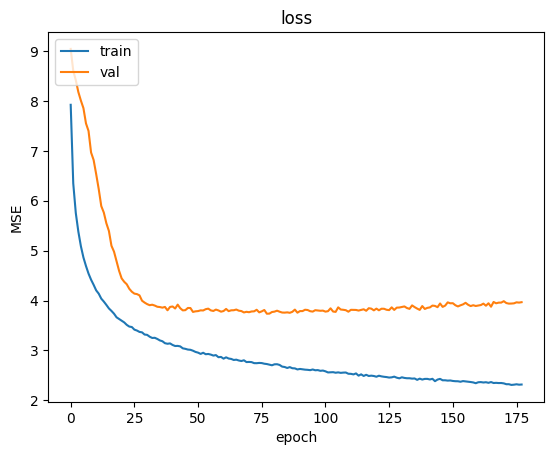

 Flights from LAS to DCA:


  0%|          | 0/1 [00:00<?, ?it/s]

 ------------- ****** LAS-DCA-1) ****** ------------- 
fcst_start and fcst_end for LAS-DCA at FCST_ID 1 are: 180, 1619
 For market (LAS-DCA-1) , we have 860.0 Pre-Covid data, 481.0 Post-Covid data, and 180.0 future data (from now to one year from now)
13/13 [==============================] - 1s 27ms/step
val plot LAS-DCA


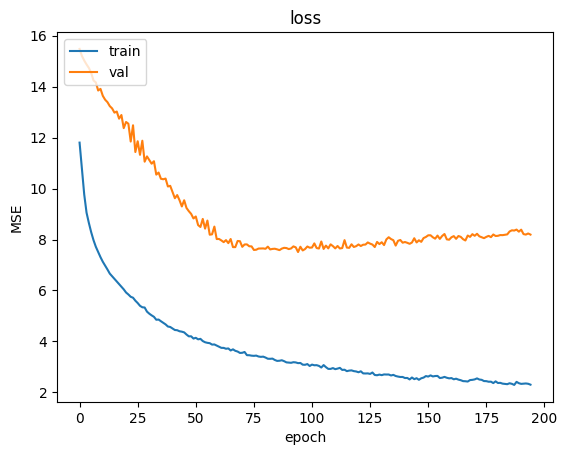

 Flights from LAS to DFW:


  0%|          | 0/13 [00:00<?, ?it/s]

 ------------- ****** LAS-DFW-1) ****** ------------- 
fcst_start and fcst_end for LAS-DFW at FCST_ID 1 are: 180, 324
 For market (LAS-DFW-1) , we have 28.0 Pre-Covid data, 470.0 Post-Covid data, and 106.0 future data (from now to one year from now)
 *** The Pre Covid data is less than the post covid data, so we ignore LAS-DFW-1 market ***
 ------------- ****** LAS-DFW-2) ****** ------------- 
fcst_start and fcst_end for LAS-DFW at FCST_ID 2 are: 325, 428
 For market (LAS-DFW-2) , we have 853.0 Pre-Covid data, 482.0 Post-Covid data, and 180.0 future data (from now to one year from now)
 ------------- ****** LAS-DFW-3) ****** ------------- 
fcst_start and fcst_end for LAS-DFW at FCST_ID 3 are: 429, 509
 For market (LAS-DFW-3) , we have 188.0 Pre-Covid data, 459.0 Post-Covid data, and 178.0 future data (from now to one year from now)
 *** The Pre Covid data is less than the post covid data, so we ignore LAS-DFW-3 market ***
 ------------- ****** LAS-DFW-4) ****** ------------- 
fcst_star

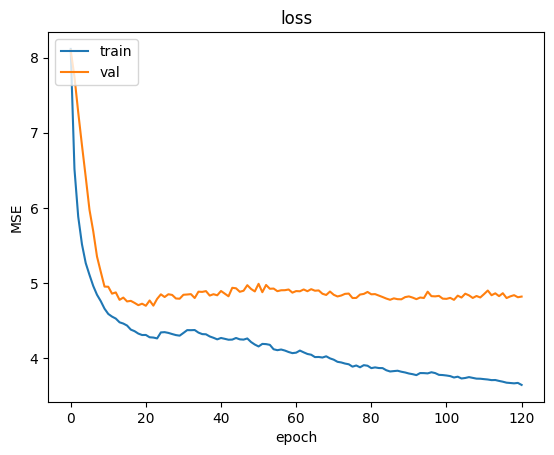

 Flights from LAS to JFK:


  0%|          | 0/3 [00:00<?, ?it/s]

 ------------- ****** LAS-JFK-1) ****** ------------- 
fcst_start and fcst_end for LAS-JFK at FCST_ID 1 are: 180, 569
 For market (LAS-JFK-1) , we have 372.0 Pre-Covid data, 0.0 Post-Covid data, and 0.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-JFK-1 market, so ignored! *** 
 ------------- ****** LAS-JFK-2) ****** ------------- 
fcst_start and fcst_end for LAS-JFK at FCST_ID 2 are: 570, 1014
 For market (LAS-JFK-2) , we have 633.0 Pre-Covid data, 2.0 Post-Covid data, and 4.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-JFK-2 market, so ignored! *** 
 ------------- ****** LAS-JFK-3) ****** ------------- 
fcst_start and fcst_end for LAS-JFK at FCST_ID 3 are: 1015, 1619
 For market (LAS-JFK-3) , we have 503.0 Pre-Covid data, 360.0 Post-Covid data, and 7.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-JFK-3 market, so ignored! *** 
No data for LAS-JFK -> No Mod

  0%|          | 0/9 [00:00<?, ?it/s]

 ------------- ****** LAS-LAX-1) ****** ------------- 
fcst_start and fcst_end for LAS-LAX at FCST_ID 1 are: 180, 389
 For market (LAS-LAX-1) , we have 304.0 Pre-Covid data, 59.0 Post-Covid data, and 34.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-LAX-1 market, so ignored! *** 
 ------------- ****** LAS-LAX-2) ****** ------------- 
fcst_start and fcst_end for LAS-LAX at FCST_ID 2 are: 390, 463
 For market (LAS-LAX-2) , we have 658.0 Pre-Covid data, 337.0 Post-Covid data, and 67.0 future data (from now to one year from now)
 ------------- ****** LAS-LAX-3) ****** ------------- 
fcst_start and fcst_end for LAS-LAX at FCST_ID 3 are: 464, 524
 For market (LAS-LAX-3) , we have 121.0 Pre-Covid data, 87.0 Post-Covid data, and 29.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-LAX-3 market, so ignored! *** 
 ------------- ****** LAS-LAX-4) ****** ------------- 
fcst_start and fcst_end for LAS-LAX at FCST_ID 

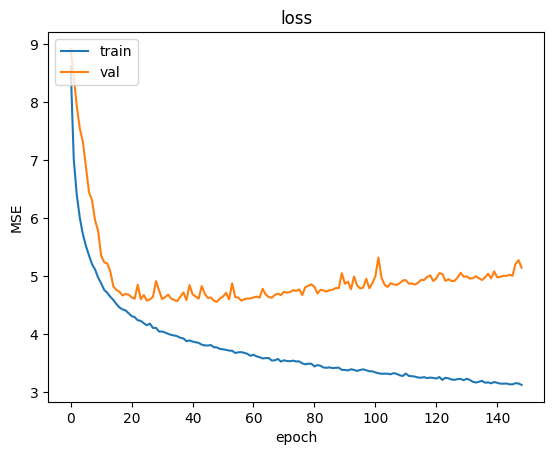

 Flights from LAS to MIA:


  0%|          | 0/4 [00:00<?, ?it/s]

 ------------- ****** LAS-MIA-1) ****** ------------- 
fcst_start and fcst_end for LAS-MIA at FCST_ID 1 are: 180, 592
 For market (LAS-MIA-1) , we have 606.0 Pre-Covid data, 46.0 Post-Covid data, and 96.0 future data (from now to one year from now)
 *** Low amount of data for either PRE, or POST of LAS-MIA-1 market, so ignored! *** 
 ------------- ****** LAS-MIA-2) ****** ------------- 
fcst_start and fcst_end for LAS-MIA at FCST_ID 2 are: 593, 1022
 For market (LAS-MIA-2) , we have 804.0 Pre-Covid data, 406.0 Post-Covid data, and 74.0 future data (from now to one year from now)
 ------------- ****** LAS-MIA-3) ****** ------------- 
fcst_start and fcst_end for LAS-MIA at FCST_ID 3 are: 1023, 1447
 For market (LAS-MIA-3) , we have 856.0 Pre-Covid data, 405.0 Post-Covid data, and 167.0 future data (from now to one year from now)
 ------------- ****** LAS-MIA-4) ****** ------------- 
fcst_start and fcst_end for LAS-MIA at FCST_ID 4 are: 1448, 1619
 For market (LAS-MIA-4) , we have 20.0 Pr

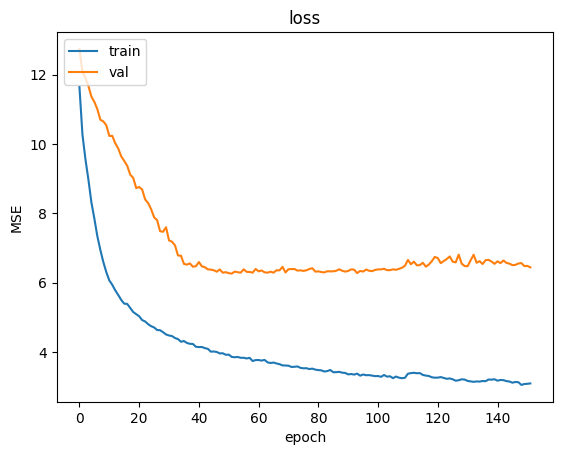

 Flights from LAS to NRT:


  0%|          | 0/1 [00:00<?, ?it/s]

 ------------- ****** LAS-NRT-1) ****** ------------- 
fcst_start and fcst_end for LAS-NRT at FCST_ID 1 are: 180, 1619
 For market (LAS-NRT-1) , we have 9.0 Pre-Covid data, 0.0 Post-Covid data, and 0.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-NRT-1 market, so ignored! *** 
No data for LAS-NRT -> No Model!
 Flights from LAS to ORD:


  0%|          | 0/7 [00:00<?, ?it/s]

 ------------- ****** LAS-ORD-1) ****** ------------- 
fcst_start and fcst_end for LAS-ORD at FCST_ID 1 are: 180, 461
 For market (LAS-ORD-1) , we have 758.0 Pre-Covid data, 304.0 Post-Covid data, and 134.0 future data (from now to one year from now)
 ------------- ****** LAS-ORD-2) ****** ------------- 
fcst_start and fcst_end for LAS-ORD at FCST_ID 2 are: 462, 625
 For market (LAS-ORD-2) , we have 624.0 Pre-Covid data, 426.0 Post-Covid data, and 101.0 future data (from now to one year from now)
 ------------- ****** LAS-ORD-3) ****** ------------- 
fcst_start and fcst_end for LAS-ORD at FCST_ID 3 are: 626, 770
 For market (LAS-ORD-3) , we have 858.0 Pre-Covid data, 474.0 Post-Covid data, and 150.0 future data (from now to one year from now)
 ------------- ****** LAS-ORD-4) ****** ------------- 
fcst_start and fcst_end for LAS-ORD at FCST_ID 4 are: 771, 854
 For market (LAS-ORD-4) , we have 11.0 Pre-Covid data, 372.0 Post-Covid data, and 174.0 future data (from now to one year from no

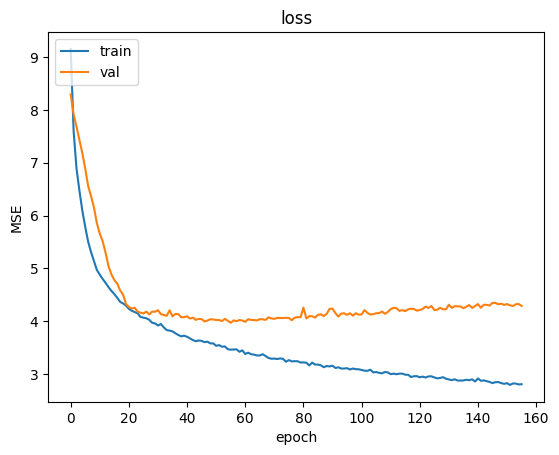

 Flights from LAS to PHL:


  0%|          | 0/5 [00:00<?, ?it/s]

 ------------- ****** LAS-PHL-1) ****** ------------- 
fcst_start and fcst_end for LAS-PHL at FCST_ID 1 are: 180, 453
 For market (LAS-PHL-1) , we have 570.0 Pre-Covid data, 45.0 Post-Covid data, and 149.0 future data (from now to one year from now)
 *** Low amount of data for either PRE, or POST of LAS-PHL-1 market, so ignored! *** 
 ------------- ****** LAS-PHL-2) ****** ------------- 
fcst_start and fcst_end for LAS-PHL at FCST_ID 2 are: 454, 607
 For market (LAS-PHL-2) , we have 594.0 Pre-Covid data, 290.0 Post-Covid data, and 38.0 future data (from now to one year from now)
 ------------- ****** LAS-PHL-3) ****** ------------- 
fcst_start and fcst_end for LAS-PHL at FCST_ID 3 are: 608, 802
 For market (LAS-PHL-3) , we have 696.0 Pre-Covid data, 337.0 Post-Covid data, and 169.0 future data (from now to one year from now)
 ------------- ****** LAS-PHL-4) ****** ------------- 
fcst_start and fcst_end for LAS-PHL at FCST_ID 4 are: 803, 1091
 For market (LAS-PHL-4) , we have 153.0 Pre-

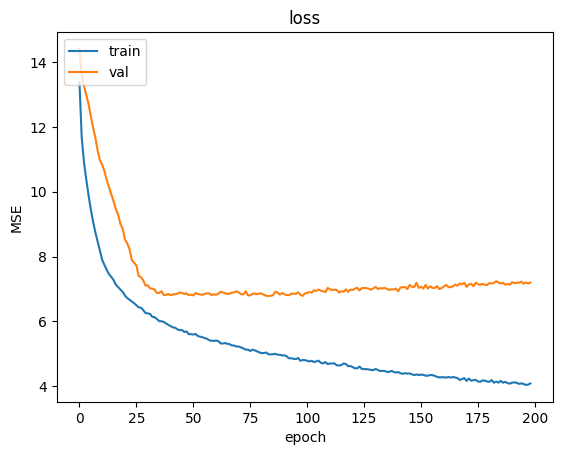

 Flights from LAS to PHX:


  0%|          | 0/7 [00:00<?, ?it/s]

 ------------- ****** LAS-PHX-1) ****** ------------- 
fcst_start and fcst_end for LAS-PHX at FCST_ID 1 are: 180, 423
 For market (LAS-PHX-1) , we have 876.0 Pre-Covid data, 477.0 Post-Covid data, and 149.0 future data (from now to one year from now)
 ------------- ****** LAS-PHX-2) ****** ------------- 
fcst_start and fcst_end for LAS-PHX at FCST_ID 2 are: 424, 530
 For market (LAS-PHX-2) , we have 100.0 Pre-Covid data, 54.0 Post-Covid data, and 2.0 future data (from now to one year from now)
 *** There is no future flights for the LAS-PHX-2 market, so ignored! *** 
 ------------- ****** LAS-PHX-3) ****** ------------- 
fcst_start and fcst_end for LAS-PHX at FCST_ID 3 are: 531, 667
 For market (LAS-PHX-3) , we have 847.0 Pre-Covid data, 459.0 Post-Covid data, and 146.0 future data (from now to one year from now)
 ------------- ****** LAS-PHX-4) ****** ------------- 
fcst_start and fcst_end for LAS-PHX at FCST_ID 4 are: 668, 922
 For market (LAS-PHX-4) , we have 866.0 Pre-Covid data, 4

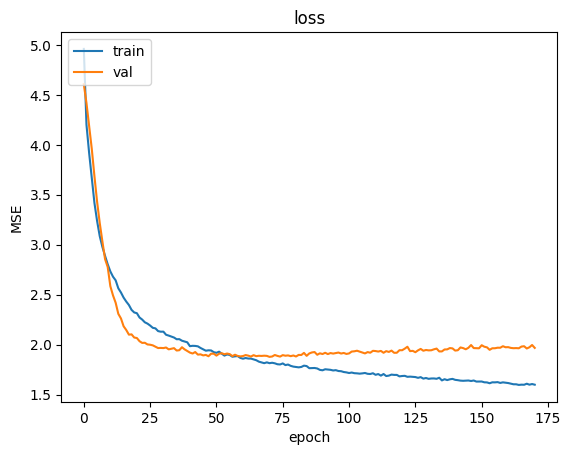

 Flights from LAS to SJC:


DatabaseError: Execution failed on sql: 
    select Distinct LEG_ORIG_S as orig, LEG_DEST_S as dest, FCST_ID as fcst_id,
            TIME_BAND_START as time_band_start, TIME_BAND_END as time_band_end
    from fcst.fcst_id_ref
    where 1=1 
    and LEG_ORIG_S = 'LAS'
    and LEG_DEST_S = 'SJC'
    order by 1,2,3,4
    
DPI-1080: connection was closed by ORA-3135
unable to rollback

In [11]:
from tqdm.notebook import trange, tqdm
from collections import defaultdict
from sklearn.utils import shuffle

switch_orig_dist = False
orig = "LAS"

yesterday =  datetime.today() - timedelta(days=2)
next_year_today = datetime.today() + timedelta(days=365)

pull_start = '2017-09-01'
pull_end = next_year_today.strftime("%Y-%m-%d")

# Pre: pre-covid period, used for train and validation
Pre_start, Pre_end = '2017-09-01', '2020-01-30'
# Post: post-covid period, used for test
Post_start, Post_end = '2021-07-01',  yesterday.strftime("%Y-%m-%d")
# Future: Today till one year in future:
future_start , future_end = datetime.today().strftime("%Y-%m-%d") ,   next_year_today.strftime("%Y-%m-%d")

new_market= False
ulcc_list = ['NK','SY','F9'] # Spirit SunCountry Frontier 

# Extracting for Seas:
sea_col_fcst = ['week_x', 'week_y', 'forecastDayOfWeek','avgrasm','dowavgrasm', 'forecastId'] #+ forecastDayOfWeek, FCST
sea_col_Cap = ['week_x', 'week_y','dow_x', 'dow_y', 'avgrasm','seats_AA_fcst','seats_OA_fcst','seats_ulcc_fcst' , 'seats_AA' , 'seats_OA' , 'seats_ulcc']
sea_col = ['week_x', 'week_y', 'dow_x', 'dow_y','avgrasm','dowavgrasm']

# Data reshaping parameters:
train_val_percentage = .9
time_series = False
seasenality_one_dimension = False 
window = 0 

# Model parameters;
epochs = 150
early_stop = 10
sea_dense = 128




kronos_3_timeseries = defaultdict()

hcrt, mos, az = connect_to_servers()


# Pull all the dest given rig.
all_dest = find_all_dest_given_leg(orig , hcrt)
all_dest.pop(0) # Remove Austin

print(f"There are {len(all_dest)} FCSTs from {orig}")

if switch_orig_dist:
    main_dest = orig

for dest in tqdm(all_dest):
    if switch_orig_dist:
        dest , orig = main_dest, dest
    print(f" Flights from {orig} to {dest}:")
    # Pull all the FCSTs
    fcst_id_df = get_fcst_given_leg(orig, dest, hcrt )   
    
    if len(fcst_id_df) == 0:
        print(f" *** Fot the {orig}-{dest}, there is no avilable FCSTs! *** ")
        continue 
    # Pull OAG:
    oag_df = get_oag_data(orig, dest, pull_start, pull_end, ulcc_list, mos)
    
    #Pull prdMaps:
    prdMaps = get_prdMaps(orig, dest, hcrt)
    

    # Processing: OAG Per Day:
    oag_kl_total_Per_Day_and_AA = oag_per_day(oag_df)
    
    all_tensors = [[] for i in range(12)]
    
    for _,_ , fcst_id , fcst_start , fcst_end in tqdm(fcst_id_df.values):
        
        hcrt, mos, az = connect_to_servers()
        
        print(f" ------------- ****** {orig}-{dest}-{fcst_id}) ****** ------------- ")
        
        # print( fcst_id , fas, adf )
        print( f"fcst_start and fcst_end for {orig}-{dest} at FCST_ID {fcst_id} are: {fcst_start}, {fcst_end}") 
        
        #  Processing: OAG per FCST:
        oag_kl =  oag_per_fcst(oag_df, fcst_start, fcst_end )
        
        # Merge and Normalize: OAG per FCST and OAG per Day:
        oag_kl_fcst_total = pd.merge(oag_kl,oag_kl_total_Per_Day_and_AA ,on = "adj_dep_date", how='left',suffixes=('_fcst', '_day'))
        oag_kl_fcst_total = normalize_oag_kl_fcst_total(oag_kl_fcst_total)
        
        
        # Pull data from the file: pullData_FullPeriod.py
        df = pull_data(orig,dest,fcst_id,new_market)
        df = pull_seas(df, orig, dest)
        
        if len(df) < 100:
            print(f"insufficent data for market ({orig}-{dest}-{fcst_id}), IGNORED")
            continue
            
        
        df['flightDepartureDate'] = pd.to_datetime(df['flightDepartureDate'], format='%Y/%m/%d')

        # Merge new features (including the total day seats) into current Kronos dataset by dep_date
        df = pd.merge(df,oag_kl_fcst_total, left_on=['flightDepartureDate'],\
              right_on=['adj_dep_date'], how='left')
        df.dropna(inplace=True)
        
        # processing: Group and pad the DF:
        post = group_and_pad(df)
        
        # Cut the 'post' data into Pre-covid and Post-covid parts
        Data_PRE = post[ (post['flightDepartureDate']>=Pre_start) & (post['flightDepartureDate']<=Pre_end) ]
        Data_POST = post[ (post['flightDepartureDate']>=Post_start) & (post['flightDepartureDate']<=Post_end) ]
        Data_FUTURE = post[ (post['flightDepartureDate']>=future_start) & (post['flightDepartureDate']<=future_end) ]

        Data_PRE = Data_PRE.reset_index(drop = True)
        Data_POST = Data_POST.reset_index(drop = True)
        Data_FUTURE = Data_FUTURE.reset_index(drop = True)

        print(f" For market ({orig}-{dest}-{fcst_id}) , we have {Data_PRE.shape[0]/14} Pre-Covid data, {Data_POST.shape[0]/14} Post-Covid data, and {Data_FUTURE.shape[0]/14} future data (from now to one year from now)")
        
        # TODO: This can be edited later, so we use the POST data to train....
        if len(Data_PRE) <= len(Data_POST):
            print(f" *** The Pre Covid data is less than the post covid data, so we ignore {orig}-{dest}-{fcst_id} market ***")
            continue
        
#         # TODO: When merging models together this can be useefull for training porposes, but for now not usefull.
        if len(Data_FUTURE)//14 <= 5 * 7:
            print(f" *** There is no future flights for the {orig}-{dest}-{fcst_id} market, so ignored! *** ")
            continue
        
        if any([Data_PRE.shape[0]/14 <= 10 * 7 , Data_POST.shape[0]/14 <= 10 * 7]):
            print(f" *** Low amount of data for either PRE, or POST of {orig}-{dest}-{fcst_id} market, so ignored! *** ")
            continue
                
        # MErge FCSTs:
            
        # Train Kronos 2 (No Additional Feat (using sea_col)):
        use_channels = True
        seasenality_one_dimension = True
        DOW= True
        FC_time_series = False
        traffic_time_series = True 
        window = 10
        train, val, test = get_train_test_samples2(Data_PRE, Data_POST, Data_FUTURE, sea_col_fcst, prdMaps , DOW= DOW , train_val_percentage = train_val_percentage ,  FC_time_series = FC_time_series , traffic_time_series = traffic_time_series,  use_channels = use_channels , seasenality_one_dimension = seasenality_one_dimension ,  window = window )
        
        [all_tensors[i].append(item) for i,item in enumerate( train + val +test)]
        
    if len(all_tensors[0]) == 0:
        print(f"No data for {orig}-{dest} -> No Model!")
        continue
    # Now concatinate and shuffle the data:
    train = [np.concatenate(all_tensors[i]) for i in range(0,4)] 
    val = [np.concatenate(all_tensors[i]) for i in range(4,8)] 
    test = [np.concatenate(all_tensors[i]) for i in range(8,12)] 
    
    # Shuffle:
    train = shuffle(train[0],train[1],train[2],train[3])
    val = shuffle(val[0],val[1],val[2],val[3])
    
    
    kronos32s_test_results3 , kronos32s_hist3,  kronos32s_model3 = kronos_32s_model(para_epochs = 500, para_early_stop =  True, para_model_name = 'kronos32s', para_sea_len = len(sea_col_fcst), para_sea_dense =  160, window = window ,
             train_list = train , val_list = val, test_list = test)

    _ , results_summary = test_acc(kronos32s_test_results3, test[3])

    kronos_3_timeseries[f"{orig}-{dest}"] = results_summary

    print(f"val plot {orig}-{dest}")
    plt.plot(kronos32s_hist3.history['loss'])
    plt.plot(kronos32s_hist3.history['val_loss'])
    plt.title('loss')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['train','val'] , loc = "upper left")
    plt.show()
        

        

## NEW Experiment (Given a Fake Today)

In [22]:
import warnings
warnings.filterwarnings('ignore')

print("Ignoring the warnings")

Ignoring the warnings


In [23]:
def randPeriod(prdMaps):
    # print(x)
    random_period = np.random.randint(1,7)
    rrd_start, rrt_end = prdMaps[prdMaps['FORECASTPERIOD']==random_period].loc[:,["RRD_START", "RRD_END"]].values[0]
    random_day = np.random.randint(rrd_start, rrt_end )
    return random_period , random_day


def tf_timeseries_masking( tf_tensors , data_index , prdMaps , window  ):
    """This function will generate masked time-seried terrafic data."""
    
    random_period , random_day_to_dept = randPeriod(prdMaps)
    # print(random_period , random_day_to_dept )
    arr =  prdMaps.iloc[:,3].values
    
    # output = tf_tensors[data_index].copy()
    test_tensors = tf_tensors.copy()
    test_tensors[data_index][:,:random_period,] = -1
    
    
    max_bond_period = random_day_to_dept
    min_bond_period = arr[random_period-1]
    remaining_window = window - 1
    current_index = data_index
    max_min_range = max_bond_period - min_bond_period
    current_period = random_period

    if  max_min_range < remaining_window:
        while max_min_range  <= remaining_window:
            # print(current_index-max_min_range,current_index)
            test_tensors[current_index-max_min_range:current_index,:,:current_period,] = -1
            current_period -= 1
            if current_period == 0:
                break
            current_index -= max_min_range
            remaining_window -=  max_min_range
            max_bond_period -= max_min_range
            min_bond_period = arr[current_period-1]
            max_min_range = max_bond_period - min_bond_period
            # reaching Today date:

    if max_min_range >= remaining_window:
        # print(current_index-max_min_range,current_index)
        test_tensors[current_index-remaining_window:current_index,:,:current_period,] = -1
    
    return test_tensors[data_index+1-window:data_index+1] 


def get_tensors2(DataFarame, sea_col_Cap, prdMaps= None , FC_time_series = True , traffic_time_series = False ,  use_channels = False , seasenality_one_dimension = True ,  window = 10, DOW=False):
    
    len_sea_cap = len(sea_col_Cap)
            
    
    # fractional closure
    PRE_FC_L = DataFarame[['fracClosure_' + str(i + 1) for i in range(10)]].values.astype('float32')
    # seasonality
    PRE_Sea_L = DataFarame[sea_col_Cap].values.astype('float32')
    # actual traffic
    PRE_Traf_L = DataFarame[['trafficActual_' + str(i + 1) for i in range(10)]].values.astype('float32')
    
    
    # reshape the data for CNNLSTM model
    FC = PRE_FC_L.reshape(int(PRE_FC_L.shape[0]/14), 1, 14, 10)
    Seasenality = PRE_Sea_L.reshape(int(PRE_Sea_L.shape[0]/14), 1,14, len_sea_cap)
    Traffic = PRE_Traf_L.reshape(int(PRE_Traf_L.shape[0]/14), 1, 14, 10)
    
    # Remove Duplicates (from 2d to 1d vector)
    if seasenality_one_dimension:
        Seasenality =np.delete(Seasenality, slice(13), 2).reshape(Seasenality.shape[0],len_sea_cap)
    
    
    if use_channels:
        FC = FC.reshape(len(FC),2,7,10)
        Traffic = Traffic.reshape(len(Traffic),2,7,10)
    
    # Change FC shape to refelect time series:
    # print(FC.shape)
    if FC_time_series:
        time_series_widow= list()
        Seasenality_times = list()
        for i in range(window,len(FC)):
            # print(FC[i-window:i].shape)
            time_series_widow.append(FC[i-window:i].reshape(window,2,7,10))
            # print((Seasenality[i-window:i].shape))
            Seasenality_times.append(Seasenality[i-window:i])
        FC = np.array(time_series_widow)
        Seasenality = np.array(Seasenality_times)
        
        # Since the 1st window size data points are removed:
        # Seasenality = Seasenality[window:]
        Traffic = Traffic[window:]
    
    elif traffic_time_series:
        traffic_time_series_window = list()
        Seasenality_times = list()
        for i in range(window,len(Traffic)):
            # Find Random period and random day:
            if DOW:
                tf_window_masked = tf_timeseries_masking_DOW( Traffic  , i , prdMaps , window  )
            else:
                tf_window_masked = tf_timeseries_masking( Traffic  , i , prdMaps , window  )
            traffic_time_series_window.append(tf_window_masked)
            # Seasenality_times.append(Seasenality[i-window:i])
        TF_time = np.array(traffic_time_series_window)
        # Seasenality = np.array(Seasenality_times)
        Seasenality = Seasenality[window:]
        FC = FC[window:]
        
        Traffic = Traffic[window:]
            
        return FC, Seasenality, Traffic, TF_time
    
        
    return FC, Seasenality, Traffic, _




def floorSearch(arr, low, high, x):
 
    # If low and high cross each other
    if (low > high):
        return -1
 
    # If last element is smaller than x
    if (x >= arr[high]):
        return high
 
    # Find the middle point
    mid = int((low + high) / 2)
 
    # If middle point is floor.
    if (arr[mid] == x):
        return mid
 
    # If x lies between mid-1 and mid
    if (mid > 0 and arr[mid-1] <= x
            and x < arr[mid]):
        return mid - 1
 
    # If x is smaller than mid,
    # floor must be in left half.
    if (x < arr[mid]):
        return floorSearch(arr, low, mid-1, x)
 
    # If mid-1 is not floor and x is greater than
    # arr[mid],
    return floorSearch(arr, mid + 1, high, x)


def tf_timeseries_masking_DOW( tf_tensors , data_index , prdMaps , window  ):
    """This function will generate masked time-seried terrafic data, and is based on DOW."""
    
    random_period , random_day_to_dept = randPeriod(prdMaps)
    arr =  prdMaps.iloc[:,3].values
    test_tensors = tf_tensors.copy()
    
    day_to_dept = random_day_to_dept
    current_index = data_index
    
    for i in range(0,window):
        # Move back 7 days in each iter.
        day_to_dept = random_day_to_dept - i*7 
        # Get the period of that day to dept.
        flrs = floorSearch(arr, 0, 6, day_to_dept)
        current_period = flrs+1
        # If we get today, will break the loop. and use all the values (no masking)
        if current_period == 0:
            break
        # mask the values
        test_tensors[current_index,:,:current_period,] = -1
        
        # Update index:
        current_index -= 1
        
    return test_tensors[data_index+1-window:data_index+1]    
    
def get_prdMaps(orig, dest, hcrt):
    """TODO: add the lcl_flw_ind and change the data to mask diffrent between the local and Flow Traffics"""
    
    prdMaps = pd.read_sql(f"""select DISTINCT leg_orig as origin, leg_dest as destination, fcst_period as forecastPeriod, rrd_band_start_i as rrd_start, rrd_band_end_i as rrd_end 
                            -- , lcl_flw_ind
                            from market_xref a 
                            join FCST.FCST_PERIOD_REF b 
                            on a.infl_period_id = b.FCST_PERIOD_ID
                            where 1=1 
                            and cabin_code = 'Y'
                            and leg_orig = '{orig}'
                            and leg_dest = '{dest}'
                            and lcl_flw_ind = 'L'
                            ORDER BY forecastPeriod
                            """, con = hcrt)
    return prdMaps
        


# def dow_get_tensors2(DataFarame , sea_col_Cap, prdMaps= None  ,  test = False, time_series = True,  use_channels = False , window = 10):   
# def dow_get_tensors2(DataFarame , sea_col_Cap, prdMaps= None  ,  FC_time_series = True , traffic_time_series = False ,  use_channels = False , seasenality_one_dimension = True ,  window = 10):
#     DOW = True
#     FC_dow , Seasenality_dow, Traffic_dow ,  TF_time_dow  = list(), list(), list(), list()
    
#     for i in DataFarame.loc[ :,	['forecastDayOfWeek' ]].drop_duplicates().values:
#         # filter_y = DataFarame['dow_y' ] == i[1] 
#         # filter_x = DataFarame['dow_x'] == i[0] 
#         filter_dow =  DataFarame['forecastDayOfWeek'] == i[0] 
#         # print(filter_y.shape , filter_x.shape)
#         # print(i)
#         Data_dow =DataFarame[filter_dow]
#         # print(Data_dow.shape)
#         FC, Seasenality, Traffic, TF_time= get_tensors2(Data_dow, sea_col_Cap, prdMaps  , FC_time_series  , traffic_time_series ,  use_channels  , seasenality_one_dimension  ,  window, DOW )
#         FC_dow.append(FC)
#         Seasenality_dow.append(Seasenality)
#         Traffic_dow.append(Traffic)
#         if traffic_time_series:
#             TF_time_dow.append(TF_time)
    
#     # Then Concat together, now each datapoint is based on DOW.
#     FC_dow = [ i  for i in FC_dow if i.shape!=(0,)]
#     Seasenality_dow = [ i  for i in Seasenality_dow if i.shape!=(0,)]
#     # Traffic_dow = [ i  for i in Traffic_dow if i.shape!=(0,)]
    
#     if traffic_time_series:
#         TF_time_dow = [ i  for i in TF_time_dow if i.shape!=(0,)]
#         TF_time_dow = np.concatenate(TF_time_dow)
    
#     FC_dow = np.concatenate(FC_dow)
#     Seasenality_dow = np.concatenate(Seasenality_dow)
#     Traffic_dow = np.concatenate(Traffic_dow)
    
#     return FC_dow , Seasenality_dow, Traffic_dow , TF_time_dow



    
def dow_get_tensors2(DataFarame , sea_col_Cap , prdMaps= None  ,  FC_time_series = True , traffic_time_series = False ,  use_channels = False , seasenality_one_dimension = True ,  window = 10 , random_masking = True, test_today = None):
    DOW = True
    FC_dow, Seasenality_dow, Traffic_dow , TF_time_dow = defaultdict() ,  defaultdict() ,  defaultdict(),  defaultdict()
    
    if not random_masking:
        masked_df = create_masking_based_on_given_day(DataFarame,test_today, prdMaps )
    
    for i in DataFarame.loc[ :,	['forecastDayOfWeek' ]].drop_duplicates().values:
        # filter_y = DataFarame['dow_y' ] == i[1] 
        # filter_x = DataFarame['dow_x'] == i[0] 
        filter_dow =  DataFarame['forecastDayOfWeek'] == i[0] 
        # print(filter_y.shape , filter_x.shape)
        # print(i)
        Data_dow =DataFarame[filter_dow]
        # print(Data_dow.shape)
        if random_masking:
            FC, Seasenality, Traffic, TF_time= get_tensors2(Data_dow, sea_col_Cap, prdMaps  , FC_time_series  , traffic_time_series ,  use_channels  , seasenality_one_dimension  ,  window, DOW )
        else :
            Data_dow_masked = masked_df[filter_dow]
            FC, Seasenality, Traffic, TF_time= get_tensors2_faketoday(Data_dow, Data_dow_masked ,  sea_col_Cap , use_channels , seasenality_one_dimension ,  window)
            
        # FC, Seasenality, Traffic, TF_time= get_tensors2_faketoday(Data_dow, Data_dow_masked ,  sea_col_Cap , use_channels , seasenality_one_dimension ,  window)
        for i,j in enumerate(Data_dow.index[::14][window:]):
            FC_dow[j] = FC[i]
            Seasenality_dow[j] = Seasenality[i]
            Traffic_dow[j] = Traffic[i]
            if traffic_time_series:
                TF_time_dow[j] = TF_time[i] 

    FC_dow = np.stack(list(dict(sorted(FC_dow.items())).values()))
    Seasenality_dow = np.stack(list(dict(sorted(Seasenality_dow.items())).values()))
    Traffic_dow = np.stack(list(dict(sorted(Traffic_dow.items())).values()))
    if traffic_time_series:
        TF_time_dow = np.stack(list(dict(sorted(TF_time_dow.items())).values()))

    return FC_dow , Seasenality_dow, Traffic_dow , TF_time_dow

    
def create_masking_based_on_given_day(DataFrame,test_today,prdMaps):
    """This function maskes the data absed on a given date."""
    arr =  prdMaps.iloc[:,3].values
    try:
        test_today_index = int(DataFrame[DataFrame['forecastDepartureDate'] >= test_today].index[0]/14)
    except:
        print("No Date after the set fake today date")
        return DataFrame
    test_df = DataFrame.copy()

    current_period = 1 
    day_from_today = 0
    for current_index in range(test_today_index , len(test_df)//14):

        if current_period < 7:
            if day_from_today == arr[current_period]:
                current_period += 1
                # print(current_period)
        else: 
            current_period = 7

        day_data_df = test_df[current_index*14:(current_index+1)*14]
        day_data_df.loc[day_data_df['forecastPeriod']<= current_period , "trafficActual_1":"trafficActualAadv_10"] = -1

        day_from_today = day_from_today +1
        # break
    return test_df
    
def get_tensors2_faketoday(DataFarame, DataFarame_Masked ,  sea_col_Cap ,  use_channels = False , seasenality_one_dimension = True ,  window = 10):
    """This function uses a masekd dataframe. (it is used when we want to set a fake_today for our test set"""
    
    len_sea_cap = len(sea_col_Cap)        
    
    # fractional closure
    PRE_FC_L = DataFarame[['fracClosure_' + str(i + 1) for i in range(10)]].values.astype('float32')
    # seasonality
    PRE_Sea_L = DataFarame[sea_col_Cap].values.astype('float32')
    # actual traffic
    PRE_Traf_L = DataFarame[['trafficActual_' + str(i + 1) for i in range(10)]].values.astype('float32')
    # Masked Traffic
    PRE_Traf_L_Masked = DataFarame_Masked[['trafficActual_' + str(i + 1) for i in range(10)]].values.astype('float32')

    
    
    # reshape the data for CNNLSTM model
    FC = PRE_FC_L.reshape(int(PRE_FC_L.shape[0]/14), 1, 14, 10)
    Seasenality = PRE_Sea_L.reshape(int(PRE_Sea_L.shape[0]/14), 1,14, len_sea_cap)
    Traffic = PRE_Traf_L.reshape(int(PRE_Traf_L.shape[0]/14), 1, 14, 10)
    Traffic_Masked = PRE_Traf_L_Masked.reshape(int(PRE_Traf_L_Masked.shape[0]/14), 1, 14, 10)
    
    # Remove Duplicates (from 2d to 1d vector)
    if seasenality_one_dimension:
        Seasenality =np.delete(Seasenality, slice(13), 2).reshape(Seasenality.shape[0],len_sea_cap)
    
    
    if use_channels:
        FC = FC.reshape(len(FC),2,7,10)
        Traffic = Traffic.reshape(len(Traffic),2,7,10)
        Traffic_Masked = Traffic_Masked.reshape(len(Traffic_Masked),2,7,10)
    
    
    traffic_time_series_window = list()
    Seasenality_times = list()
    for i in range(window,len(Traffic)):
        # Get Masked Matrix
        tf_window_masked = Traffic_Masked[i+1-window:i+1]  
        traffic_time_series_window.append(tf_window_masked)
        # Seasenality_times.append(Seasenality[i-window:i])
    TF_time = np.array(traffic_time_series_window)
    # Seasenality = np.array(Seasenality_times)
    Seasenality = Seasenality[window:]
    FC = FC[window:]

    Traffic = Traffic[window:]

    return FC, Seasenality, Traffic, TF_time
    

def get_train_test_samples2(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap, prdMaps , DOW= False , train_val_percentage = 0.9  ,  FC_time_series = True , traffic_time_series = False ,  use_channels = False , seasenality_one_dimension = True ,  window = 10 ,  test_random_masking = True, test_today = None):
    """
    test_today format =  yyyy-mm-dd
    """
        
    if DOW:
        PRE_FC , PRE_Seas , PRE_Traf, PRE_TF_timeseries  =  dow_get_tensors2(Data_PRE , sea_col_Cap, prdMaps  , FC_time_series = FC_time_series , traffic_time_series = traffic_time_series ,  use_channels = use_channels , seasenality_one_dimension = seasenality_one_dimension ,   window = window, random_masking = True, test_today = None)
        POST_FC , POST_Seas , POST_Traf , POST_TF_timeseries =  dow_get_tensors2(Data_POST , sea_col_Cap, prdMaps  , FC_time_series = FC_time_series , traffic_time_series = traffic_time_series ,  use_channels = use_channels , seasenality_one_dimension = seasenality_one_dimension ,   window = window, random_masking = test_random_masking, test_today = test_today)
        # FUTURE_FC , FUTURE_Seas , FUTURE_Traf ,FUTUR_TF_timeseries = dow_get_tensors2(Data_FUTURE , sea_col_Cap, prdMaps  , FC_time_series = False , traffic_time_series = True ,  use_channels = True , seasenality_one_dimension = True ,   window = window)


    else:
        PRE_FC , PRE_Seas , PRE_Traf , PRE_TF_timeseries = get_tensors2(Data_PRE, sea_col_Cap, prdMaps  , FC_time_series = FC_time_series , traffic_time_series = traffic_time_series ,  use_channels = use_channels , seasenality_one_dimension = seasenality_one_dimension ,   window = window)
        
        if test_random_masking:
            POST_FC , POST_Seas , POST_Traf , POST_TF_timeseries = get_tensors2(Data_POST, sea_col_Cap, prdMaps , FC_time_series = FC_time_series , traffic_time_series = traffic_time_series ,  use_channels = use_channels , seasenality_one_dimension = seasenality_one_dimension ,   window = window)
        else:
            masked_df = create_masking_based_on_given_day(Data_POST,test_today, prdMaps)
            POST_FC , POST_Seas , POST_Traf , POST_TF_timeseries= get_tensors2_faketoday(Data_POST, masked_df ,  sea_col_Cap , use_channels , seasenality_one_dimension ,  window)
            
        # FUTURE_FC , FUTURE_Seas , FUTURE_Traf , FUTURE_TF_timeseries = get_tensors2(Data_FUTURE, sea_col_Cap, prdMaps , FC_time_series = False , traffic_time_series = True ,  use_channels = True , seasenality_one_dimension = True ,   window = window)

    # Train/Val Spilit:
    # TODO: THIS SHOULD BE CHANGED TO RANDOMIZED.
    train_val_cutoff = round(PRE_FC.shape[0]*train_val_percentage) 


    # prepare train/val/test datasets
    PRE_FC_train = PRE_FC[:train_val_cutoff, :]
    PRE_FC_val = PRE_FC[train_val_cutoff:, :]

    PRE_Seas_train = PRE_Seas[:train_val_cutoff, :]
    PRE_Seas_val = PRE_Seas[train_val_cutoff:, :]

    PRE_Traf_train = PRE_Traf[:train_val_cutoff, :]
    PRE_Traf_val = PRE_Traf[train_val_cutoff:, :]

    PRE_TF_timeseries_train = PRE_TF_timeseries[:train_val_cutoff, :]
    PRE_TF_timeseries_val = PRE_TF_timeseries[train_val_cutoff:, :]



    train = [PRE_FC_train,PRE_Seas_train,PRE_TF_timeseries_train,PRE_Traf_train]
    val = [PRE_FC_val,PRE_Seas_val,PRE_TF_timeseries_val,PRE_Traf_val]
    test = [POST_FC , POST_Seas ,  POST_TF_timeseries , POST_Traf]
    
    return train, val, test
    

In [24]:
from tqdm.notebook import trange, tqdm
from collections import defaultdict
from sklearn.utils import shuffle

orig = "DFW"
dest = "MIA"

DOW= True

# If test_random_masking is False -> Means you have to give it a date for creating a fake today
test_random_masking = False
test_today = '2022-06-01'

yesterday =  datetime.today() - timedelta(days=2)
next_year_today = datetime.today() + timedelta(days=365)

pull_start = '2017-09-01'
pull_end = next_year_today.strftime("%Y-%m-%d")

# Pre: pre-covid period, used for train and validation
Pre_start, Pre_end = '2017-09-01', '2020-01-30'
# Post: post-covid period, used for test
Post_start, Post_end = '2021-07-01',  yesterday.strftime("%Y-%m-%d")
# Train on All:

# Future: Today till one year in future:
future_start , future_end = datetime.today().strftime("%Y-%m-%d") ,   next_year_today.strftime("%Y-%m-%d")

new_market= False
ulcc_list = ['NK','SY','F9'] # Spirit SunCountry Frontier 

# Extracting for Seas:
sea_col_fcst = ['week_x', 'week_y', 'forecastDayOfWeek','avgrasm','dowavgrasm','seats_AA_fcst', 'holiday', 'forecastId'] #+ forecastDayOfWeek, FCST
sea_col_Cap = ['week_x', 'week_y','dow_x', 'dow_y', 'avgrasm','seats_AA_fcst','seats_OA_fcst','seats_ulcc_fcst' , 'seats_AA' , 'seats_OA' , 'seats_ulcc']
sea_col = ['week_x', 'week_y', 'dow_x', 'dow_y','avgrasm','dowavgrasm']

# Data reshaping parameters:
train_val_percentage = .9
time_series = False
seasenality_one_dimension = False 
window = 0 

# Model parameters;
epochs = 150
early_stop = 10
sea_dense = 128




kronos_3_timeseries = defaultdict()

hcrt, mos, az = connect_to_servers()


print(f" Flights from {orig} to {dest}:")
# Pull all the FCSTs
fcst_id_df = get_fcst_given_leg(orig, dest, hcrt )   

# Pull OAG:
oag_df = get_oag_data(orig, dest, pull_start, pull_end, ulcc_list, mos)

#Pull prdMaps:
prdMaps = get_prdMaps(orig, dest, hcrt)


# Processing: OAG Per Day:
oag_kl_total_Per_Day_and_AA = oag_per_day(oag_df)

all_tensors = [[] for i in range(12)]

for _,_ , fcst_id , fcst_start , fcst_end in tqdm(fcst_id_df.values):

    hcrt, mos, az = connect_to_servers()

    print(f" ------------- ****** {orig}-{dest}-{fcst_id}) ****** ------------- ")

    # print( fcst_id , fas, adf )
    print( f"fcst_start and fcst_end for {orig}-{dest} at FCST_ID {fcst_id} are: {fcst_start}, {fcst_end}") 

    #  Processing: OAG per FCST:
    oag_kl =  oag_per_fcst(oag_df, fcst_start, fcst_end )
    break

    # Merge and Normalize: OAG per FCST and OAG per Day:
    oag_kl_fcst_total = pd.merge(oag_kl,oag_kl_total_Per_Day_and_AA ,on = "adj_dep_date", how='left',suffixes=('_fcst', '_day'))
    oag_kl_fcst_total = normalize_oag_kl_fcst_total(oag_kl_fcst_total)


    # Pull data from the file: pullData_FullPeriod.py
    df = pull_data(orig,dest,fcst_id,new_market)
    df = pull_seas(df, orig, dest)

    if len(df) < 100:
        print(f"insufficent data for market ({orig}-{dest}-{fcst_id}), IGNORED")
        continue


    df['flightDepartureDate'] = pd.to_datetime(df['flightDepartureDate'], format='%Y/%m/%d')

    # Merge new features (including the total day seats) into current Kronos dataset by dep_date
    df = pd.merge(df,oag_kl_fcst_total, left_on=['flightDepartureDate'],\
          right_on=['adj_dep_date'], how='left')
    df.dropna(inplace=True)

    # processing: Group and pad the DF:
    post = group_and_pad(df)

    # Cut the 'post' data into Pre-covid and Post-covid parts
    Data_PRE = post[ (post['flightDepartureDate']>=Pre_start) & (post['flightDepartureDate']<=Pre_end) ]
    Data_POST = post[ (post['flightDepartureDate']>=Post_start) & (post['flightDepartureDate']<=Post_end) ]
    Data_FUTURE = post[ (post['flightDepartureDate']>=future_start) & (post['flightDepartureDate']<=future_end) ]
    
    Data_PRE = Data_PRE.reset_index(drop = True)
    Data_POST = Data_POST.reset_index(drop = True)
    Data_FUTURE = Data_FUTURE.reset_index(drop = True)
    
    if test_today and not test_random_masking:
        if DOW:
            split_date = (datetime.strptime(test_today,'%Y-%m-%d') - timedelta(days=window*7)).strftime("%Y-%m-%d")
        else:
            split_date = (datetime.strptime(test_today,'%Y-%m-%d') - timedelta(days=window)).strftime("%Y-%m-%d")
        
        Data_PAST = pd.concat([Data_PRE,Data_POST])
        Data_PAST =  Data_PAST[(Data_PAST['flightDepartureDate']>=Post_start)]
        
        Data_PRE = Data_PAST[Data_PAST['flightDepartureDate']<split_date]
        Data_POST = Data_PAST[Data_PAST['flightDepartureDate']>=split_date]     
        
        Data_PRE = Data_PRE.reset_index(drop = True)
        Data_POST = Data_POST.reset_index(drop = True)
    
    print(f" For market ({orig}-{dest}-{fcst_id}) , we have {Data_PRE.shape[0]/14} Pre-Covid data, {Data_POST.shape[0]/14} Post-Covid data, and {Data_FUTURE.shape[0]/14} future data (from now to one year from now)")

    # TODO: This can be edited later, so we use the POST data to train....
    if len(Data_PRE) <= len(Data_POST):
        print(f" *** The Pre Covid data is less than the post covid data, so we ignore {orig}-{dest}-{fcst_id} market ***")
        continue

#         # TODO: When merging models together this can be useefull for training porposes, but for now not usefull.
    if len(Data_FUTURE)//14 <= 5 * 7:
        print(f" *** There is no future flights for the {orig}-{dest}-{fcst_id} market, so ignored! *** ")
        continue

    if any([Data_PRE.shape[0]/14 <= 10 * 7 , Data_POST.shape[0]/14 <= 10 * 7]):
        print(f" *** Low amount of data for either PRE, or POST of {orig}-{dest}-{fcst_id} market, so ignored! *** ")
        continue
    
    # MErge FCSTs:

    # Train Kronos 2 (No Additional Feat (using sea_col)):
    use_channels = True
    seasenality_one_dimension = True
    DOW= True
    FC_time_series = False
    traffic_time_series = True 
    window = 10
    test_random_masking = False
    # test_today = '2022-07-01'
    train, val, test = get_train_test_samples2(Data_PRE, Data_POST, Data_FUTURE, sea_col_fcst, prdMaps , DOW= DOW , train_val_percentage = train_val_percentage ,  FC_time_series = FC_time_series , traffic_time_series = traffic_time_series,  use_channels = use_channels , seasenality_one_dimension = seasenality_one_dimension ,  window = window, test_random_masking = test_random_masking, test_today = test_today )

    [all_tensors[i].append(item) for i,item in enumerate( train + val +test)]

if len(all_tensors[0]) == 0:
    print(f"No data for {orig}-{dest} -> No Model!")

# Now concatinate and shuffle the data:
train = [np.concatenate(all_tensors[i]) for i in range(0,4)] 
val = [np.concatenate(all_tensors[i]) for i in range(4,8)] 
test = [np.concatenate(all_tensors[i]) for i in range(8,12)] 

# Shuffle:
train = shuffle(train[0],train[1],train[2],train[3])
val = shuffle(val[0],val[1],val[2],val[3])


kronos32s_test_results3 , kronos32s_hist3,  kronos32s_model3 = kronos_32s_model(para_epochs = 500, para_early_stop =  True, para_model_name = 'kronos32s', para_sea_len = len(sea_col_fcst), para_sea_dense =  160, window = window ,
         train_list = train , val_list = val, test_list = test)

_ , results_summary = test_acc(kronos32s_test_results3, test[3])

kronos_3_timeseries[f"{orig}-{dest}"] = results_summary

print(f"val plot {orig}-{dest}")
plt.plot(kronos32s_hist3.history['loss'])
plt.plot(kronos32s_hist3.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val'] , loc = "upper left")
plt.show()
        

        

 Flights from DFW to MIA:


  0%|          | 0/13 [00:00<?, ?it/s]

 ------------- ****** DFW-MIA-1) ****** ------------- 
fcst_start and fcst_end for DFW-MIA at FCST_ID 1 are: 180, 339
No data for DFW-MIA -> No Model!


ValueError: need at least one array to concatenate

In [25]:
type(fcst_start)

int

In [166]:
fcst_id_df

,ORIG,DEST,FCST_ID,TIME_BAND_START,TIME_BAND_END
0,DFW,MIA,1,180,339
1,DFW,MIA,2,340,409
2,DFW,MIA,3,410,471
3,DFW,MIA,4,472,587
4,DFW,MIA,5,588,692
5,DFW,MIA,6,693,833
6,DFW,MIA,7,834,937
7,DFW,MIA,8,938,994
8,DFW,MIA,9,995,1074
9,DFW,MIA,10,1075,1134


In [18]:
results_summary

{'top_FvT': [-0.6155472, 1.5767189, 2.864777],
 'mid_FvT': [-1.0097353, 4.4852295, 21.135525],
 'bot_FvT': [0.08687197, 3.8466287, 14.803124],
 'sum_FvT': [-1.5384105, 6.1794443, 40.549725]}

In [19]:
def test_acc(prediction_results, gold_labels):
    results = pd.DataFrame()
    test_size = gold_labels.shape[0]
    
    print(test_size)

    gold_tr_reshaped = gold_labels.reshape(test_size*14,10)
    pred_tr_reshaped = prediction_results.reshape(test_size*14,10)

    # Gold, top, mid, bot
    results['gold_top_tr'] = gold_tr_reshaped[:,:3].sum(1)
    results['gold_mid_tr'] = gold_tr_reshaped[:,3:7].sum(1)
    results['gold_bot_tr'] = gold_tr_reshaped[:,7:].sum(1)
    results['gold_sum_tr'] = gold_tr_reshaped.sum(1)

    # Pred Top, Mid, Bot
    results['pred_top_tr'] = pred_tr_reshaped[:,:3].sum(1)
    results['pred_mid_tr'] = pred_tr_reshaped[:,3:7].sum(1)
    results['pred_bot_tr'] = pred_tr_reshaped[:,7:].sum(1)
    results['pred_sum_tr'] = pred_tr_reshaped.sum(1)

    # all FvT errors
    results['top_FvT'] = results['pred_top_tr'] - results['gold_top_tr']
    results['mid_FvT'] = results['pred_mid_tr'] - results['gold_mid_tr']
    results['bot_FvT'] = results['pred_bot_tr'] - results['gold_bot_tr']
    results['sum_FvT'] = results['pred_sum_tr'] - results['gold_sum_tr']

    # squared FvT errors for MSE
    results['top_FvT_sqr'] = results['top_FvT']**2
    results['mid_FvT_sqr'] = results['mid_FvT']**2
    results['bot_FvT_sqr'] = results['bot_FvT']**2
    results['sum_FvT_sqr'] = results['sum_FvT']**2
    
    result_sum = { 
                    "top_FvT" : [results['top_FvT'].mean(), results['top_FvT'].std(), results['top_FvT_sqr'].mean()],
                    "mid_FvT" : [results['mid_FvT'].mean(), results['mid_FvT'].std(), results['mid_FvT_sqr'].mean()],
                    "bot_FvT" : [results['bot_FvT'].mean(), results['bot_FvT'].std(), results['bot_FvT_sqr'].mean()],
                    "sum_FvT" : [results['sum_FvT'].mean(), results['sum_FvT'].std(), results['sum_FvT_sqr'].mean()]
                }
    return results , result_sum

In [264]:
fcst = 1
multiply = 4
test_pred = kronos32s_model3.predict([ all_tensors[8][fcst].reshape(list(all_tensors[8][fcst].shape)+[1]), all_tensors[9][fcst], all_tensors[10][fcst]])

mutiplied_tensor = all_tensors[10][fcst]*multiply
mutiplied_tensor[mutiplied_tensor==-multiply] = -1
test_pred_multiplied = kronos32s_model3.predict([ all_tensors[8][fcst].reshape(list(all_tensors[8][fcst].shape)+[1]), all_tensors[9][fcst], mutiplied_tensor])

4/4 [==============================] - 0s 21ms/step


In [265]:
results , results_summary = test_acc(test_pred, all_tensors[11][fcst])
results_multiplied , results_summary_multiplied  = test_acc(test_pred_multiplied, all_tensors[11][fcst])

116
116


In [266]:
results_summary

{'top_FvT': [-0.26796037, 1.3416723, 1.8707789],
 'mid_FvT': [0.5422064, 4.6107397, 21.539818],
 'bot_FvT': [0.2459836, 3.481669, 12.175062],
 'sum_FvT': [0.52022964, 6.151494, 38.08822]}

In [267]:
results_summary_multiplied

{'top_FvT': [-0.16006874, 1.6556782, 2.765204],
 'mid_FvT': [3.25216, 8.803499, 88.030426],
 'bot_FvT': [4.3344326, 10.145432, 121.65373],
 'sum_FvT': [7.426523, 16.307524, 320.9248]}

In [268]:
print(test_today)
local_tf_table =  pd.DataFrame(columns = ["date" , "acctual", "predicted"  ])
flow_tf_table =  pd.DataFrame(columns = ["date" , "acctual", "predicted"  ])

for i in range(0,len(results)//14):
    # print(i)
    row_date = (datetime.strptime(test_today,'%Y-%m-%d') + timedelta(days=i)).strftime("%Y-%m-%d")
    flow_tf_table = flow_tf_table.append({"date" : row_date, "acctual": results.loc[14*i+7:14*(i+1),'gold_sum_tr'].sum() ,  "predicted" : results.loc[14*i+7:14*(i+1), 'pred_sum_tr'].sum() }, ignore_index=True)
    local_tf_table = local_tf_table.append({"date" : row_date, "acctual":  results.loc[14*i:14*i+7,'gold_sum_tr'].sum() ,  "predicted" : results.loc[14*i:14*i+7, 'pred_sum_tr'].sum() }, ignore_index=True)


2022-07-01


In [269]:
local_tf_table_multiplied =  pd.DataFrame(columns = ["date" , "acctual", "predicted"  ])
flow_tf_table_multiplied =  pd.DataFrame(columns = ["date" , "acctual", "predicted"  ])

for i in range(0,len(results_multiplied)//14):
    # print(i)
    row_date = (datetime.strptime(test_today,'%Y-%m-%d') + timedelta(days=i)).strftime("%Y-%m-%d")
    flow_tf_table_multiplied = flow_tf_table_multiplied.append({"date" : row_date, "acctual": results_multiplied.loc[14*i+7:14*(i+1),'gold_sum_tr'].sum() ,  "predicted" : results_multiplied.loc[14*i+7:14*(i+1), 'pred_sum_tr'].sum() }, ignore_index=True)
    local_tf_table_multiplied = local_tf_table_multiplied.append({"date" : row_date, "acctual":  results_multiplied.loc[14*i:14*i+7,'gold_sum_tr'].sum() ,  "predicted" : results_multiplied.loc[14*i:14*i+7, 'pred_sum_tr'].sum() }, ignore_index=True)


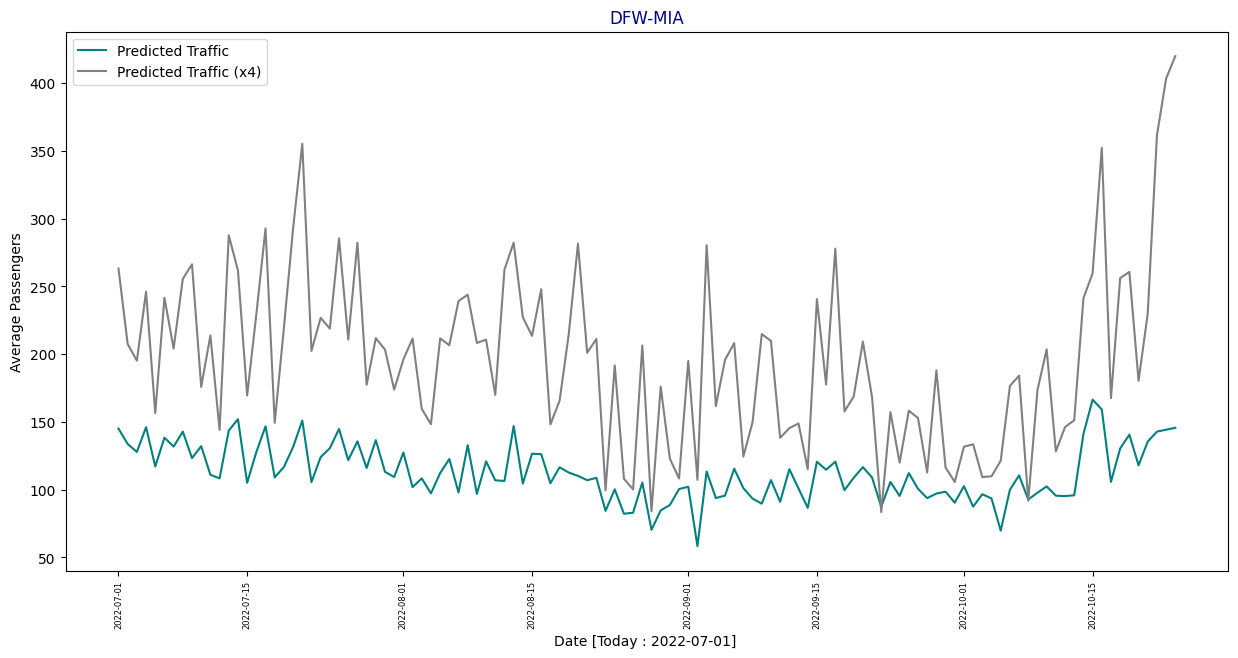

In [271]:
local_tf_table['date'] = pd.to_datetime(local_tf_table['date']) 
local_tf_table_multiplied['date'] = pd.to_datetime(local_tf_table_multiplied['date']) 


# plt.scatter(local_tf_table['date'] ,local_tf_table['acctual'], c ="salmon",
#             linewidths = 1,
#             marker =".",
#             # edgecolor ="green",
#             s = 50)
plt.figure(figsize=(15, 7)) 
# plt.plot(local_tf_table['date'] ,local_tf_table['acctual'], c ="salmon")
            # linewidths = 2,
            # marker ="s",
            # edgecolor ="green",
            # s = 50)
 
plt.plot( local_tf_table['date'] , local_tf_table['predicted'], c ="teal",)
            # linewidths = 2,
            # marker ="^",
            # edgecolor ="red",
            # s = 200)
# plt.scatter( local_tf_table['date'] , local_tf_table['predicted'], c ="teal",
#             linewidths = 1,
#             marker =".",
#             # edgecolor ="red",
#             s = 50)

plt.plot( local_tf_table_multiplied['date'] , local_tf_table_multiplied['predicted'], c ="grey",)


# plt.scatter( local_tf_table_multiplied['date'] , local_tf_table_multiplied['predicted'], c ="red",
#             # linewidths = 1,
#             marker =".",
#             # edgecolor ="red",
#             s = 50)

plt.xticks( color='black', rotation=90, fontsize='6', )



plt.xlabel(f"Date [Today : {test_today}] ")
plt.ylabel("Average Passengers")
plt.legend(['Predicted Traffic','Predicted Traffic (x4)'] , loc = "upper left")
plt.title("DFW-MIA" , color = "darkblue")
plt.show()

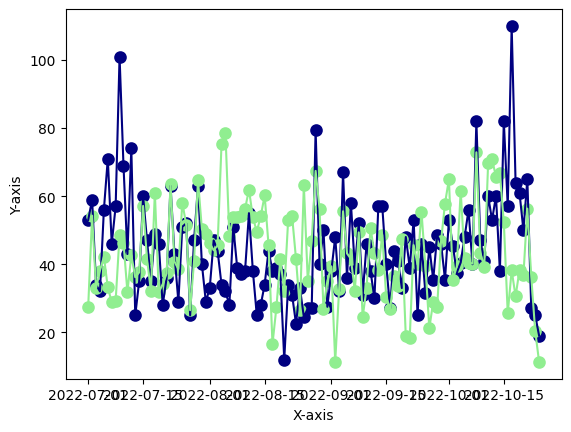

In [247]:
flow_tf_table['date'] = pd.to_datetime(flow_tf_table['date']) 
plt.scatter(flow_tf_table['date'] ,flow_tf_table['acctual'], c ="navy",
            linewidths = 2,
            marker ="o",
            # edgecolor ="green",
            s = 50)

plt.plot(flow_tf_table['date'] ,flow_tf_table['acctual'], c ="navy")
            # linewidths = 2,
            # marker ="s",
            # edgecolor ="green",
            # s = 50)
 
plt.plot( flow_tf_table['date'] , flow_tf_table['predicted'], c ="lightgreen",)
            # linewidths = 2,
            # marker ="^",
            # edgecolor ="red",
            # s = 200)
plt.scatter( flow_tf_table['date'] , flow_tf_table['predicted'], c ="lightgreen",
            linewidths = 2,
            marker ="o",
            # edgecolor ="red",
            s = 50)
 
 
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [88]:
local_tf_table

,date,acctual,predicted
0,2022-07-01,130.0,120.449783
1,2022-07-02,158.0,111.132027
2,2022-07-03,148.5,80.700012
3,2022-07-04,118.5,99.339188
4,2022-07-05,145.0,120.011574
...,...,...,...
125,2022-11-03,157.0,125.951675
126,2022-11-04,142.0,104.015289
127,2022-11-05,139.0,117.700256
128,2022-11-06,131.0,136.671539


In [107]:
results.loc[0:7,'gold_sum_tr'].sum()

105.0

In [108]:
results.loc[0:7, 'pred_sum_tr'].sum()

93.58943

In [29]:
use_channels = True
seasenality_one_dimension = True
DOW= True
FC_time_series = False
traffic_time_series = True 
window = 10
test_random_masking = False
test_today = '2022-07-01'
train, val, test = get_train_test_samples2(Data_PRE, Data_POST, Data_FUTURE, sea_col_fcst, prdMaps , DOW= DOW , train_val_percentage = train_val_percentage ,  FC_time_series = FC_time_series , traffic_time_series = traffic_time_series,  use_channels = use_channels , seasenality_one_dimension = seasenality_one_dimension ,  window = window, test_random_masking = test_random_masking, test_today = test_today )


In [464]:
    
Data_PRE = Data_PRE.reset_index(drop = True)
Data_POST = Data_POST.reset_index(drop = True)
Data_FUTURE = Data_FUTURE.reset_index(drop = True)

train, val, test = get_train_test_samples2(Data_PRE, Data_POST, Data_FUTURE, sea_col_Cap, prdMaps , DOW= False , train_val_percentage = 0.9  ,  FC_time_series = False , traffic_time_series = True ,  use_channels = True , seasenality_one_dimension = True ,  window = 10 ,  test_random_masking = False, test_today = test_today)


In [33]:
train[0].shape

(257, 2, 7, 10)

2022-02-28


In [487]:
Data_PAST = pd.concat([Data_PRE,Data_POST])

Data_PAST =  Data_PAST[(Data_PAST['flightDepartureDate']>=Post_start)]

In [488]:
Data_PAST

,snapshotDate,origin,destination,forecastId,forecastDepartureDate,forecastDayOfWeek,poolCode,cabinCode,forecastPeriod,localFlowIndicator,flightDepartureDate,fracClosure_1,fracClosure_2,fracClosure_3,fracClosure_4,fracClosure_5,fracClosure_6,fracClosure_7,fracClosure_8,fracClosure_9,fracClosure_10,trafficActual_1,trafficActual_2,trafficActual_3,trafficActual_4,trafficActual_5,trafficActual_6,trafficActual_7,trafficActual_8,trafficActual_9,trafficActual_10,trafficActualAadv_1,trafficActualAadv_2,trafficActualAadv_3,trafficActualAadv_4,trafficActualAadv_5,trafficActualAadv_6,trafficActualAadv_7,trafficActualAadv_8,trafficActualAadv_9,trafficActualAadv_10,holiday,H1,H2,H3,HL,weekNumber,week_x,week_y,dow_x,dow_y,avgtraffic,avgtrafficopenness,avgrasm,dowavgtraffic,dowavgtrafficopenness,dowavgrasm,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All,groupID,fullHistory,real
0,2022-11-10,LAS,PHX,1.0,2021-07-01,4.0,M,Y,1.0,F,2021-07-01,0.20,0.32,0.48,0.60,0.72,0.77,0.850,0.900,0.960,0.990,0.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.000718,0.534132,0.037,0.713,0.478,0.690,0.212,0.176,0.141,0.153,2021-07-01,180.0,423.0,0.092784,0.550314,0.510989,0.669611,0.0,0.5,0.5,0.666667,0.092784,0.669611,0.716842,0.630015,0.601307,0.640684,0.666667,0.571429,0.6,0.578947,0.716842,0.640684,928,14,1.0
1,2022-11-10,LAS,PHX,1.0,2021-07-01,4.0,M,Y,2.0,F,2021-07-01,0.02,0.16,0.32,0.48,0.57,0.67,0.750,0.800,0.850,0.960,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.000718,0.534132,0.037,0.713,0.478,0.690,0.212,0.176,0.141,0.153,2021-07-01,180.0,423.0,0.092784,0.550314,0.510989,0.669611,0.0,0.5,0.5,0.666667,0.092784,0.669611,0.716842,0.630015,0.601307,0.640684,0.666667,0.571429,0.6,0.578947,0.716842,0.640684,928,14,1.0
2,2022-11-10,LAS,PHX,1.0,2021-07-01,4.0,M,Y,3.0,F,2021-07-01,0.00,0.09,0.21,0.40,0.53,0.63,0.690,0.700,0.810,0.970,2.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.000718,0.534132,0.037,0.713,0.478,0.690,0.212,0.176,0.141,0.153,2021-07-01,180.0,423.0,0.092784,0.550314,0.510989,0.669611,0.0,0.5,0.5,0.666667,0.092784,0.669611,0.716842,0.630015,0.601307,0.640684,0.666667,0.571429,0.6,0.578947,0.716842,0.640684,928,14,1.0
3,2022-11-10,LAS,PHX,1.0,2021-07-01,4.0,M,Y,4.0,F,2021-07-01,0.00,0.09,0.17,0.32,0.44,0.63,0.720,0.770,0.900,0.990,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.000718,0.534132,0.037,0.713,0.478,0.690,0.212,0.176,0.141,0.153,2021-07-01,180.0,423.0,0.092784,0.550314,0.510989,0.669611,0.0,0.5,0.5,0.666667,0.092784,0.669611,0.716842,0.630015,0.601307,0.640684,0.666667,0.571429,0.6,0.578947,0.716842,0.640684,928,14,1.0
4,2022-11-10,LAS,PHX,1.0,2021-07-01,4.0,M,Y,5.0,F,2021-07-01,0.00,0.12,0.22,0.30,0.41,0.58,0.720,0.820,0.940,1.000,0.0,0.0,0.0,2.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.000718,0.534132,0.037,0.713,0.478,0.690,0.212,0.176,0.141,0.153,2021-07-01,180.0,423.0,0.092784,0.550314,0.510989,0.669611,0.0,0.5,0.5,0.666667,0.092784,0.669611,0.716842,0.630015,0.601307,0.640684,0.666667,0.571429,0.6,0.578947,0.716842,0.640684,928,14,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6813,2022-11-10,LAS,PHX,1.0,2022-11-08,2.0,M,Y,3.0,L,2022-11-08,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.

In [468]:
# kronos32s_test_results_fcst1 , kronos32s_hist_fcst1 ,  kronos32s_model_fcst1  = kronos_32s_model(para_epochs = 500, para_early_stop =  True, para_model_name = 'kronos32s', para_sea_len = len(sea_col_fcst), para_sea_dense =  160, window = window ,
#          train_list = train_fcst1 , val_list = val_fcst1, test_list = test_fcst1)

# _ , results_summary = test_acc(kronos32s_test_results_fcst1, test_fcst1[3])

# print(f"val plot {orig}-{dest}")
# plt.plot(kronos32s_hist_fcst1.history['loss'])
# plt.plot(kronos32s_hist_fcst1.history['val_loss'])
# plt.title('loss')
# plt.ylabel('MSE')
# plt.xlabel('epoch')
# plt.legend(['train','val'] , loc = "upper left")
# plt.show()

In [ ]:
print(f"val plot {orig}-{dest}")
plt.plot(kronos32s_hist_fcst1.history['loss'])
plt.plot(kronos32s_hist_fcst1.history['val_loss'],'#008000--')
plt.plot(kronos32s_hist3.history['loss'])
plt.plot(kronos32s_hist3.history['val_loss'],'--')
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val' , 'train_all' , 'val_all'] , loc = "upper left")
plt.show()

In [36]:
kronos_3_timeseries

defaultdict(None,
            {'LAS-CLT': {'top_FvT': [-0.70858854, 2.3051896, 5.815697],
              'mid_FvT': [-1.2077943, 5.0697293, 27.159475],
              'bot_FvT': [-0.30967426, 5.3101206, 28.29169],
              'sum_FvT': [-2.226057, 7.8932123, 67.254616]},
             'LAS-DCA': {'top_FvT': [-1.2648538, 4.127817, 18.635769],
              'mid_FvT': [-1.6137515, 5.4140353, 31.91088],
              'bot_FvT': [-0.18573946, 4.7471156, 22.56569],
              'sum_FvT': [-3.0643444, 7.816067, 70.4705]},
             'LAS-DFW': {'top_FvT': [-0.3669899, 4.383461, 19.348886],
              'mid_FvT': [-1.8249222, 4.843649, 26.79063],
              'bot_FvT': [-0.6342519, 4.4038424, 19.795572],
              'sum_FvT': [-2.826164, 7.655265, 66.58868]},
             'LAS-LAX': {'top_FvT': [-0.4462558, 1.800803, 3.4418461],
              'mid_FvT': [-0.42050594, 3.6261582, 13.325081],
              'bot_FvT': [-0.4359237, 6.3574767, 40.60518],
              'sum_FvT': [-1.3026

In [13]:
prdMaps

,ORIGIN,DESTINATION,FORECASTPERIOD,RRD_START,RRD_END
0,LAS,PHX,1,2,6
1,LAS,PHX,2,7,13
2,LAS,PHX,3,14,20
3,LAS,PHX,4,21,29
4,LAS,PHX,5,30,49
5,LAS,PHX,6,50,119
6,LAS,PHX,6,50,149
7,LAS,PHX,7,120,331
8,LAS,PHX,7,150,331


In [20]:
df = pull_data(orig,dest,fcst_id,new_market)
df = pull_seas(df, orig, dest)

In [13]:
len(fcst_id_df)

1

In [13]:
orig, dest = dest, orig

In [26]:
Data_PRE.shape[0]/14 < 10

False

In [23]:
Data_POST.shape[0]/14 <10

True

In [24]:
Data_PRE.shape[0]/14 < 10

False

In [28]:
any([Data_PRE.shape[0]/14 < 10, Data_POST.shape[0]/14 <10, Data_PRE.shape[0]/14 < 10])

False

In [14]:
orig, dest

('CLT', 'LAS')

In [22]:
_ , results_summary = test_acc(kronos32s_test_results3, test[3])
results_summary

{'top_FvT': [-0.8999413, 2.6835864, 8.011278],
 'mid_FvT': [-1.2645532, 5.2219486, 28.866884],
 'bot_FvT': [-0.72112995, 5.0007334, 25.526485],
 'sum_FvT': [-2.885624, 7.9360704, 71.30583]}

In [20]:
results_summary

In [243]:
kronos32s_test_results3 , kronos32s_hist3,  kronos32s_model3 = kronos_32s_model(para_epochs = 500, para_early_stop =  True, para_model_name = 'kronos32s', para_sea_len = len(sea_col_fcst), para_sea_dense =  160, window = window ,
             train_list = train , val_list = val, test_list = test)

Epoch 1/500
33/33 - 13s - loss: 7.6571 - val_loss: 8.6129 - 13s/epoch - 408ms/step
Epoch 2/500
33/33 - 8s - loss: 6.1628 - val_loss: 8.1412 - 8s/epoch - 240ms/step
Epoch 3/500
33/33 - 8s - loss: 5.5592 - val_loss: 7.8799 - 8s/epoch - 240ms/step
Epoch 4/500
33/33 - 8s - loss: 5.2159 - val_loss: 7.5329 - 8s/epoch - 238ms/step
Epoch 5/500
33/33 - 9s - loss: 4.9552 - val_loss: 7.1375 - 9s/epoch - 260ms/step
Epoch 6/500
33/33 - 9s - loss: 4.7556 - val_loss: 6.8388 - 9s/epoch - 268ms/step
Epoch 7/500
33/33 - 8s - loss: 4.5983 - val_loss: 6.5289 - 8s/epoch - 245ms/step
Epoch 8/500
33/33 - 8s - loss: 4.4475 - val_loss: 6.2290 - 8s/epoch - 250ms/step
Epoch 9/500
33/33 - 9s - loss: 4.3191 - val_loss: 5.8533 - 9s/epoch - 260ms/step
Epoch 10/500
33/33 - 8s - loss: 4.2257 - val_loss: 5.4638 - 8s/epoch - 245ms/step
Epoch 11/500
33/33 - 8s - loss: 4.1401 - val_loss: 5.0620 - 8s/epoch - 239ms/step
Epoch 12/500
33/33 - 8s - loss: 4.0429 - val_loss: 4.8254 - 8s/epoch - 254ms/step
Epoch 13/500
33/33 - 9s

All FCST:


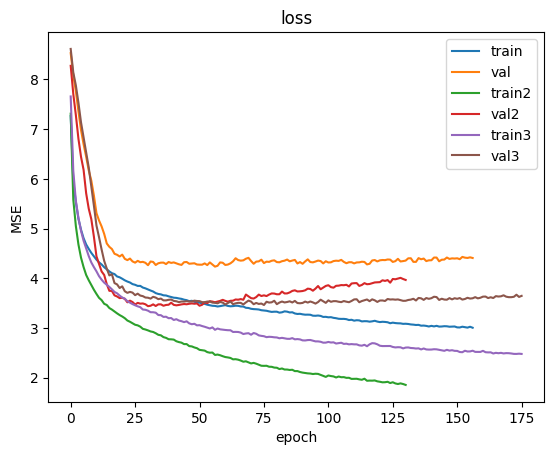

In [244]:
print( "All FCST:")
plt.plot(kronos32s_hist.history['loss'])
plt.plot(kronos32s_hist.history['val_loss'])
plt.plot(kronos32s_hist2.history['loss'])
plt.plot(kronos32s_hist2.history['val_loss'])
plt.plot(kronos32s_hist3.history['loss'])
plt.plot(kronos32s_hist3.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val','train2','val2','train3','val3'] , loc = "upper right")
plt.show()


All FCST:


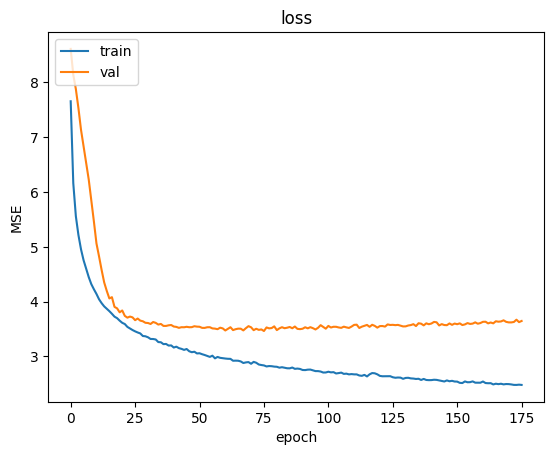

In [245]:
print( "All FCST:")
plt.plot(kronos32s_hist3.history['loss'])
plt.plot(kronos32s_hist3.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val'] , loc = "upper left")
plt.show()


In [35]:
test[3].shape

(2035, 2, 7, 10)

In [352]:
kronos32s_test_results3[0].sum(1)[:,7:].sum(1)

array([75.35593, 30.36102], dtype=float32)

In [412]:
kronos32s_test_results3.sum(2)[:,:,7:].sum(2).shape

(2035, 2)

In [421]:
kronos32s_test_results3[:,:,:,:].sum(-1).sum(-1).sum(-1).shape

(2035,)

In [433]:
# results = pd.DataFrame()
# # results['pred_bot_local', 'pred_bot_flow'] = 
# # df_new = pd.concat([df, pd.DataFrame(mat)], axis=1)
# gold_tr = test[3]
# # Predictions:
# results = pd.concat( [
#                       # Predictions:
#                       pd.DataFrame(kronos32s_test_results3[:,:,:,:3].sum(-1).sum(-1) , columns=['pred_top_local', 'pred_top_flow'])   , 
#                       pd.DataFrame(kronos32s_test_results3[:,:,:,3:7].sum(-1).sum(-1) , columns=['pred_mid_local', 'pred_mid_flow'])  , 
#                       pd.DataFrame(kronos32s_test_results3[:,:,:,7:].sum(-1).sum(-1) , columns=['pred_bot_local', 'pred_bot_flow'])   ,
#                       pd.DataFrame(kronos32s_test_results3[:,:,:,:].sum(-1).sum(-1).sum(-1) , columns=['pred_total']) ,
#                       # Gold labels:
#                       pd.DataFrame(gold_tr[:,:,:,:3].sum(-1).sum(-1) , columns=['gold_top_local', 'gold_top_flow'])   , 
#                       pd.DataFrame(gold_tr[:,:,:,3:7].sum(-1).sum(-1) , columns=['gold_mid_local', 'gold_mid_flow'])  , 
#                       pd.DataFrame(gold_tr[:,:,:,7:].sum(-1).sum(-1) , columns=['gold_bot_local', 'gold_bot_flow'])   ,
#                       pd.DataFrame(gold_tr[:,:,:,:].sum(-1).sum(-1).sum(-1) , columns=['gold_total'])
#                      ], axis=1)



# # all FvT errors
# results['top_local_FvT'] = results['pred_top_local'] - results['gold_top_local']
# results['top_flow_FvT'] = results['pred_top_flow'] - results['gold_top_flow']
# results['mid_local_FvT'] = results['pred_mid_local'] - results['gold_mid_local']
# results['mid_flow_FvT'] = results['pred_mid_flow'] - results['gold_mid_flow']
# results['bot_local_FvT'] = results['pred_bot_local'] - results['gold_bot_local']
# results['bot_flow_FvT'] = results['pred_bot_flow'] - results['gold_bot_flow']
# results['sum_FvT'] = results['pred_total'] - results['gold_total']

# # squared FvT errors for MSE
 
# results['top_local_sqr'] = results['top_local_FvT'] **2
# results['top_flow_sqr'] = results['top_flow_FvT'] **2
# results['mid_local_sqr'] = results['mid_local_FvT'] **2
# results['mid_flow_sqr'] = results['mid_flow_FvT'] **2
# results['bot_local_sqr'] = results['bot_local_FvT'] **2
# results['bot_flow_sqr'] = results['bot_flow_FvT'] **2
# results['sum_sqr'] = results['sum_FvT'] **2


# results

,pred_top_local,pred_top_flow,pred_mid_local,pred_mid_flow,pred_bot_local,pred_bot_flow,pred_total,gold_top_local,gold_top_flow,gold_mid_local,gold_mid_flow,gold_bot_local,gold_bot_flow,gold_total,top_local_FvT,top_flow_FvT,mid_local_FvT,mid_flow_FvT,bot_local_FvT,bot_flow_FvT,sum_FvT,top_local_sqr,top_flow_sqr,mid_local_sqr,mid_flow_sqr,bot_local_sqr,bot_flow_sqr,sum_sqr
0,0.000000,0.0,2.958069,0.000000,75.355927,30.361019,108.675018,0.0,0.0,14.0,0.0,92.0,9.0,115.0,0.000000,0.0,-11.041931,0.000000,-16.644073,21.361019,-6.324982,0.000000,0.0,121.924240,0.000000,277.025177,456.293152,40.005394
1,0.000000,0.0,7.977245,0.353440,87.840004,14.155909,110.326591,0.0,0.0,11.0,1.0,71.0,51.0,134.0,0.000000,0.0,-3.022755,-0.646560,16.840004,-36.844093,-23.673409,0.000000,0.0,9.137046,0.418040,283.585724,1357.487183,560.430298
2,0.000000,0.0,4.852542,0.000000,80.452316,21.876717,107.181572,0.0,0.0,18.0,0.0,72.0,47.0,137.0,0.000000,0.0,-13.147458,0.000000,8.452316,-25.123283,-29.818428,0.000000,0.0,172.855652,0.000000,71.441650,631.179382,889.138672
3,0.000000,0.0,41.687767,0.476103,90.885445,14.454760,147.504074,2.0,0.0,26.0,3.0,87.0,44.0,162.0,-2.000000,0.0,15.687767,-2.523897,3.885445,-29.545240,-14.495926,4.000000,0.0,246.106033,6.370057,15.096680,872.921204,210.131866
4,0.000000,0.0,19.629152,0.782191,79.833054,38.594898,138.839294,0.0,0.0,23.0,2.0,64.0,71.0,160.0,0.000000,0.0,-3.370848,-1.217809,15.833054,-32.405102,-21.160706,0.000000,0.0,11.362615,1.483058,250.685593,1050.090576,447.775452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,0.911937,0.0,52.654552,13.955371,52.432827,4.099748,124.054443,6.0,0.0,32.0,0.0,44.0,3.0,85.0,-5.088063,0.0,20.654552,13.955371,8.432827,1.099748,39.054443,25.888388,0.0,426.610535,194.752380,71.112572,1.209446,1525.249512
2031,0.731711,0.0,57.520550,13.217874,50.122272,0.000000,121.592400,1.0,0.0,35.0,2.0,50.0,9.0,97.0,-0.268289,0.0,22.520550,11.217874,0.122272,-9.000000,24.592400,0.071979,0.0,507.175171,125.840691,0.014951,81.000000,604.786133
2032,0.968086,0.0,45.511688,14.451297,60.976009,1.539039,123.446121,0.0,0.0,10.0,2.0,43.0,9.0,64.0,0.968086,0.0,35.511688,12.451297,17.976009,-7.460961,59.446121,0.937190,0.0,1261.079956,155.034790,323.136902,55.665943,3533.841309
2033,1.201265,0.0,52.733433,12.851460,64.121346,3.242785,134.150299,6.0,0.0,35.0,7.0,70.0,21.0,139.0,-4.798736,0.0,17.733433,5.851460,-5.878654,-17.757215,-4.849701,23.027864,0.0,314.474640,34.239590,34.558578,315.318695,23.519600


In [436]:
# top/mid/bot/sum - FvT mean/std/MSE
print('Kronos_32s, window 10')
# print([results['top_FvT'].mean(), results['top_FvT'].std(), results['top_FvT_sqr'].mean()])
# print([results['mid_FvT'].mean(), results['mid_FvT'].std(), results['mid_FvT_sqr'].mean()])
# print([results['bot_FvT'].mean(), results['bot_FvT'].std(), results['bot_FvT_sqr'].mean()])
print([results['sum_FvT'].mean(), results['sum_FvT'].std(), results['sum_sqr'].mean()])



Kronos_32s, window 10
[-38.311626, 32.109543, 2498.2969]


In [437]:
results = pd.DataFrame()

test_size = test[3].shape[0]

gold_tr_reshaped = test[3].reshape(test_size*14,10)
pred_tr_reshaped = kronos32s_test_results3.reshape(test_size*14,10)

# Gold, top, mid, bot
results['gold_top_tr'] = gold_tr_reshaped[:,:3].sum(1)
results['gold_mid_tr'] = gold_tr_reshaped[:,3:7].sum(1)
results['gold_bot_tr'] = gold_tr_reshaped[:,7:].sum(1)
results['gold_sum_tr'] = gold_tr_reshaped.sum(1)

# Pred Top, Mid, Bot
results['pred_top_tr'] = pred_tr_reshaped[:,:3].sum(1)
results['pred_mid_tr'] = pred_tr_reshaped[:,3:7].sum(1)
results['pred_bot_tr'] = pred_tr_reshaped[:,7:].sum(1)
results['pred_sum_tr'] = pred_tr_reshaped.sum(1)

# all FvT errors
results['top_FvT'] = results['pred_top_tr'] - results['gold_top_tr']
results['mid_FvT'] = results['pred_mid_tr'] - results['gold_mid_tr']
results['bot_FvT'] = results['pred_bot_tr'] - results['gold_bot_tr']
results['sum_FvT'] = results['pred_sum_tr'] - results['gold_sum_tr']

# squared FvT errors for MSE
results['top_FvT_sqr'] = results['top_FvT']**2
results['mid_FvT_sqr'] = results['mid_FvT']**2
results['bot_FvT_sqr'] = results['bot_FvT']**2
results['sum_FvT_sqr'] = results['sum_FvT']**2

results 
# pd.DataFrame(POST_Traf_DOW_32S[1].reshape(14,10)[:,7:]).sum(1)

,gold_top_tr,gold_mid_tr,gold_bot_tr,gold_sum_tr,pred_top_tr,pred_mid_tr,pred_bot_tr,pred_sum_tr,top_FvT,mid_FvT,bot_FvT,sum_FvT,top_FvT_sqr,mid_FvT_sqr,bot_FvT_sqr,sum_FvT_sqr
0,0.0,0.0,3.0,3.0,0.0,1.244709,0.934284,2.178993,0.0,1.244709,-2.065716,-0.821007,0.0,1.549299,4.267182,0.674053
1,0.0,0.0,3.0,3.0,0.0,1.713360,5.859541,7.572901,0.0,1.713360,2.859541,4.572901,0.0,2.935604,8.176977,20.911427
2,0.0,8.0,23.0,31.0,0.0,0.000000,12.785015,12.785015,0.0,-8.000000,-10.214985,-18.214985,0.0,64.000000,104.345917,331.785675
3,0.0,4.0,13.0,17.0,0.0,0.000000,12.714215,12.714215,0.0,-4.000000,-0.285785,-4.285785,0.0,16.000000,0.081673,18.367950
4,0.0,0.0,37.0,37.0,0.0,0.000000,31.157757,31.157757,0.0,0.000000,-5.842243,-5.842243,0.0,0.000000,34.131805,34.131805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28485,0.0,0.0,5.0,5.0,0.0,2.501276,0.000000,2.501276,0.0,2.501276,-5.000000,-2.498724,0.0,6.256381,25.000000,6.243623
28486,0.0,0.0,11.0,11.0,0.0,1.189321,0.951126,2.140447,0.0,1.189321,-10.048874,-8.859552,0.0,1.414484,100.979866,78.491669
28487,0.0,0.0,9.0,9.0,0.0,1.153782,3.085463,4.239244,0.0,1.153782,-5.914537,-4.760756,0.0,1.331212,34.981747,22.664793
28488,0.0,0.0,4.0,4.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,-4.000000,-4.000000,0.0,0.000000,16.000000,16.000000


In [441]:
# top/mid/bot/sum - FvT mean/std/MSE
print('Kronos_32s, window 10')
print([results['top_FvT'].mean(), results['top_FvT'].std(), results['top_FvT_sqr'].mean()])
print([results['mid_FvT'].mean(), results['mid_FvT'].std(), results['mid_FvT_sqr'].mean()])
print([results['bot_FvT'].mean(), results['bot_FvT'].std(), results['bot_FvT_sqr'].mean()])
print([results['sum_FvT'].mean(), results['sum_FvT'].std(), results['sum_FvT_sqr'].mean()])

Kronos_32s, window 10
[-0.8331702, 2.6450481, 7.690206]
[-0.99377126, 5.151972, 27.529465]
[-0.9096032, 5.0401506, 26.229605]
[-2.7365446, 7.8466167, 69.05591]


In [248]:
results[0:14]

,gold_top_tr,gold_mid_tr,gold_bot_tr,gold_sum_tr,pred_top_tr,pred_mid_tr,pred_bot_tr,pred_sum_tr,top_FvT,mid_FvT,bot_FvT,sum_FvT,top_FvT_sqr,mid_FvT_sqr,bot_FvT_sqr,sum_FvT_sqr
0,0.0,0.0,3.0,3.0,0.0,1.244709,0.934284,2.178993,0.0,1.244709,-2.065716,-0.821007,0.0,1.549299,4.267182,0.674053
1,0.0,0.0,3.0,3.0,0.0,1.713360,5.859541,7.572901,0.0,1.713360,2.859541,4.572901,0.0,2.935604,8.176977,20.911427
2,0.0,8.0,23.0,31.0,0.0,0.000000,12.785015,12.785015,0.0,-8.000000,-10.214985,-18.214985,0.0,64.000000,104.345917,331.785675
3,0.0,4.0,13.0,17.0,0.0,0.000000,12.714215,12.714215,0.0,-4.000000,-0.285785,-4.285785,0.0,16.000000,0.081673,18.367950
4,0.0,0.0,37.0,37.0,0.0,0.000000,31.157757,31.157757,0.0,0.000000,-5.842243,-5.842243,0.0,0.000000,34.131805,34.131805
5,0.0,2.0,13.0,15.0,0.0,0.000000,11.905115,11.905115,0.0,-2.000000,-1.094885,-3.094885,0.0,4.000000,1.198773,9.578312
6,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
8,0.0,0.0,1.0,1.0,0.0,0.000000,13.822845,13.822845,0.0,0.000000,12.822845,12.822845,0.0,0.000000,164.425339,164.425339
9,0.0,0.0,1.0,1.0,0.0,0.000000,3.841236,3.841236,0.0,0.000000,2.841236,2.841236,0.0,0.000000,8.072622,8.072622


In [249]:
print(test[3][0].astype(int).sum(1))

[[ 0  0  0  1  1  5  7  4 42 46]
 [ 0  0  0  0  0  0  0  0  0  9]]


In [252]:
print(kronos32s_test_results3[0].astype(int).sum(1))

[[ 0  0  0  0  0  0  0  2 30 37]
 [ 0  0  0  0  0  0  0  0  2 26]]


In [205]:
test[0].shape

(2035, 2, 7, 10)

In [206]:
train[2][1].shape

(10, 2, 7, 10)

In [312]:
trafficby12 = train[2][2] * 3
trafficby12[trafficby12 == -3] = -1


In [313]:
train[0][2]

array([[[0.143, 0.145, 0.184, 0.22 , 0.239, 0.622, 0.681, 0.754, 0.815,
         0.95 ],
        [0.15 , 0.15 , 0.151, 0.154, 0.161, 0.309, 0.403, 0.445, 0.609,
         0.876],
        [0.064, 0.064, 0.064, 0.064, 0.065, 0.07 , 0.094, 0.13 , 0.353,
         0.826],
        [0.   , 0.   , 0.   , 0.   , 0.001, 0.001, 0.002, 0.052, 0.358,
         0.972],
        [0.   , 0.   , 0.   , 0.   , 0.001, 0.001, 0.002, 0.062, 0.482,
         0.988],
        [0.   , 0.   , 0.   , 0.   , 0.001, 0.004, 0.012, 0.193, 0.668,
         0.986],
        [0.005, 0.005, 0.007, 0.007, 0.013, 0.024, 0.069, 0.426, 0.929,
         0.998]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.042],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.269],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.875],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.21 ,
         1.   ],
        [0.   , 0. 

In [314]:
example_pred = kronos32s_model3.predict([train[0][2].reshape(1,2,7,10,1), train[1][2].reshape(1,6),  trafficby12.reshape(1,10,2,7,10).astype(int)])

1/1 [==============================] - 0s 36ms/step


In [319]:
train[1][2]

array([0.9911803, 0.593716 , 1.       , 0.       , 0.538    , 6.       ],
      dtype=float32)

In [315]:
train[2][2][-1].astype(int)

array([[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  1,  1,  2,  3,  9,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  2,  3,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],

       [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]])

In [316]:
train[3][2].astype(int)

array([[[ 0,  0,  0,  0,  0,  0,  1,  2,  2,  0],
        [ 0,  0,  0,  0,  0,  0,  1,  1,  3, 10],
        [ 0,  3,  0,  0,  0,  0,  4,  0,  4, 19],
        [ 0,  0,  0,  0,  1,  1,  2,  3,  9,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  2,  3,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]])

In [317]:
example_pred.astype(int)

array([[[[ 0,  0,  0,  0,  1,  1,  0,  0,  5,  3],
         [ 0,  0,  2,  0,  1,  1,  0,  1,  1,  5],
         [ 0,  0,  0,  0,  0,  0,  0,  1, 10,  7],
         [ 0,  0,  0,  0,  0,  0,  0,  4, 18,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  1,  2,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],

        [[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  1,  5,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]]])

In [318]:
example_pred.astype(int).sum()

79

In [273]:
example_pred.astype(int)

array([[[[ 0,  0,  0,  0,  1,  0,  0,  0,  4,  1],
         [ 0,  0,  0,  0,  0,  0,  1,  0,  2,  5],
         [ 0,  0,  0,  0,  0,  0,  0,  0, 10, 11],
         [ 0,  0,  0,  0,  0,  0,  0,  2, 10,  3],
         [ 0,  0,  0,  0,  0,  0,  0,  1,  4,  3],
         [ 0,  0,  0,  0,  0,  0,  0,  1,  2,  3],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],

        [[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]]])

In [263]:
kronos32s_model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 7, 10, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 10, 2, 7, 1  0           []                               
                                0)]                                                               
                                                                                                  
 conv3d (Conv3D)                (None, 2, 7, 10, 8)  224         ['input_1[0][0]']                
                                                                                              

In [240]:
kronos32s_model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 7, 10, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 10, 2, 7, 1  0           []                               
                                0)]                                                               
                                                                                                  
 conv3d (Conv3D)                (None, 2, 7, 10, 8)  224         ['input_1[0][0]']                
                                                                                              

In [241]:
kronos32s_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 10, 2, 7, 1  0           []                               
                                0)]                                                               
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 10, 16, 7, 1  10432       ['input_4[0][0]']                
                                0)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 16, 7, 1  40         ['conv_lstm2d[0][0]']            
 alization)                     0)                                                            